# EMNIST Letter Gradient-Based Attack with SimpleCNN

This notebook implements a gradient-based attack to reconstruct letter images from the EMNIST dataset using a Simple Convolutional Neural Network (CNN). The attack optimizes random noise to match target letters (A-Z) by minimizing classification, perceptual, and total variation losses. Metrics like SSIM, MSE, and model confidence are calculated.

**Instructions**:
- Set `letters` to a single letter (e.g., `'A'`), a list of letters (e.g., `['A', 'B', 'C']`), or `None` to process all letters (A-Z).
- Run all cells sequentially to execute the attack and generate outputs.
- Install dependencies if needed (see below).

**Dependencies** (install in Colab if not already present):
```bash
!pip install torch==2.3.0 torchvision==0.18.0 pandas==2.2.2 numpy==1.26.4 matplotlib==3.8.4 scikit-image==0.23.2
```

In [15]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from skimage.metrics import structural_similarity as ssim
import os
from IPython.display import Image, display

# Set letters to a single letter (e.g., 'A'), a list (e.g., ['A', 'B', 'C']), or None for all letters
letters = None   # Change to ['A', 'B', 'C'] or None to process all letters (A-Z)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


## Load Dataset and Define Model

Loads the EMNIST dataset (`letters` split) and defines the `SimpleCNN` model with two convolutional layers and two fully connected layers.

In [16]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Dataset and DataLoader
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.EMNIST(root='./data', split='letters', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataset = datasets.EMNIST(root='./data', split='letters', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Model definition
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding=1)
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 26)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def get_features(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return F.max_pool2d(x, 2)

model = SimpleCNN().to(device)

## Train or Load Model

Trains the model for 10 epochs if no checkpoint exists, or loads the pre-trained model from `./emnist_cnn.pth`.

In [17]:
# Load or train model
model_path = './emnist_cnn.pth'
if not os.path.exists(model_path):
    print('Training model...')
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()
    model.train()
    for epoch in range(10):
        total_loss = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = loss_fn(outputs, labels - 1)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}')
    torch.save(model.state_dict(), model_path)
else:
    print('Loading existing model...')
    model.load_state_dict(torch.load(model_path, map_location=device))

model.eval()

Loading existing model...


SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=12544, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=26, bias=True)
)

## Utility Functions

Defines functions to compute metrics (SSIM, MSE, confidence) and total variation loss for the attack.

In [19]:
# Utility functions
def compute_metrics(original, reconstructed, reconstructed_tensor, target_label):
    mse = np.mean((original - reconstructed) ** 2)
    ssim_val = ssim(original, reconstructed, data_range=1.0)
    with torch.no_grad():
        probs = F.softmax(model(reconstructed_tensor), dim=1)
        pred = torch.argmax(probs).item() + 1
        conf = probs[0, target_label - 1].item()
    return ssim_val, mse, pred, conf

def total_variation_loss(img):
    batch_size, _, h, w = img.size()
    tv_h = torch.sum((img[:, :, 1:, :] - img[:, :, :-1, :]) ** 2)
    tv_w = torch.sum((img[:, :, :, 1:] - img[:, :, :, :-1]) ** 2)
    return (tv_h + tv_w) / (batch_size * h * w)

## Run Gradient-Based Attack

Performs the gradient-based attack for the specified letter(s), optimizing random noise to reconstruct target images. Logs metrics and generates progression plots.

Evaluating for letter A
Step 50: SSIM=-0.0324, MSE=0.2931, Conf=1.0000, Snapshot shape=(28, 28)
Step 100: SSIM=-0.0274, MSE=0.2797, Conf=0.9999, Snapshot shape=(28, 28)
Step 200: SSIM=-0.0127, MSE=0.2559, Conf=0.9994, Snapshot shape=(28, 28)
Step 300: SSIM=0.0063, MSE=0.2379, Conf=0.9992, Snapshot shape=(28, 28)
Step 500: SSIM=0.0615, MSE=0.2085, Conf=0.9991, Snapshot shape=(28, 28)
Step 1000: SSIM=0.2544, MSE=0.1492, Conf=0.9995, Snapshot shape=(28, 28)
Step 2000: SSIM=0.6808, MSE=0.0601, Conf=1.0000, Snapshot shape=(28, 28)
Step 4000: SSIM=0.8367, MSE=0.0214, Conf=1.0000, Snapshot shape=(28, 28)
Step 8000: SSIM=0.8970, MSE=0.0047, Conf=1.0000, Snapshot shape=(28, 28)
Step 10000: SSIM=0.9077, MSE=0.0047, Conf=1.0000, Snapshot shape=(28, 28)


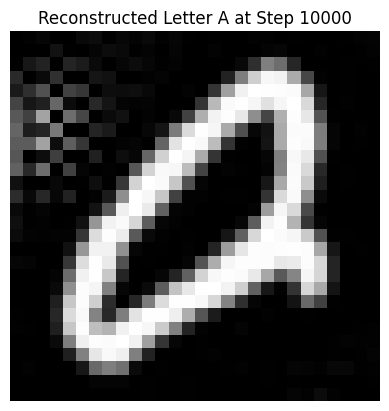

Stored 11 snapshots for letter A

Results Table for Letter A:
Step | SSIM   | MSE    | Confidence
-----|--------|--------|-----------
0    | 0.0000 | 1.0000 | 0.0000
50   | -0.0324 | 0.2931 | 1.0000
100  | -0.0274 | 0.2797 | 0.9999
200  | -0.0127 | 0.2559 | 0.9994
300  | 0.0063 | 0.2379 | 0.9992
500  | 0.0615 | 0.2085 | 0.9991
1000 | 0.2544 | 0.1492 | 0.9995
2000 | 0.6808 | 0.0601 | 1.0000
4000 | 0.8367 | 0.0214 | 1.0000
8000 | 0.8970 | 0.0047 | 1.0000
10000 | 0.9077 | 0.0047 | 1.0000
Plotting progression for letter A, 11 snapshots
Saved progression plot: /content/reconstructed_letter_A.png


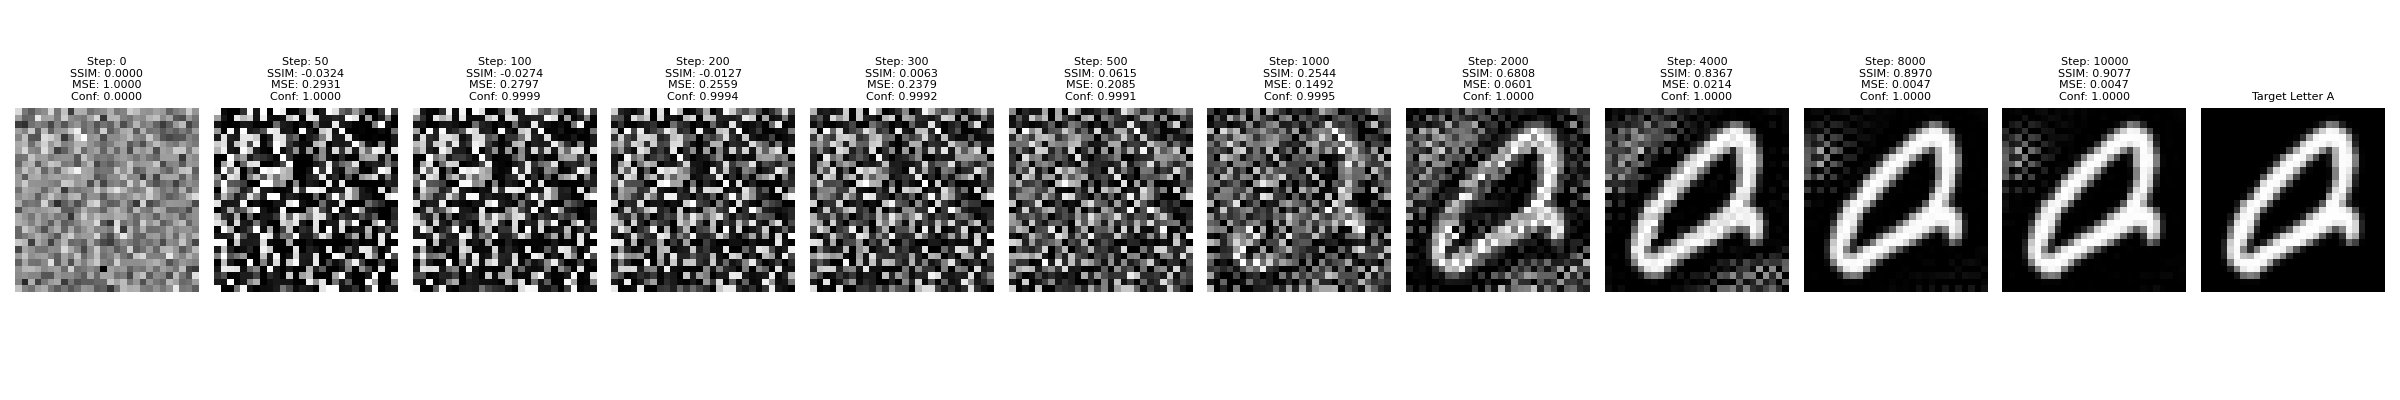

Evaluating for letter B
Step 50: SSIM=0.0112, MSE=0.2780, Conf=1.0000, Snapshot shape=(28, 28)
Step 100: SSIM=0.0370, MSE=0.2561, Conf=0.9993, Snapshot shape=(28, 28)
Step 200: SSIM=0.1092, MSE=0.2195, Conf=0.9997, Snapshot shape=(28, 28)
Step 300: SSIM=0.1916, MSE=0.1905, Conf=0.9997, Snapshot shape=(28, 28)
Step 500: SSIM=0.3861, MSE=0.1398, Conf=1.0000, Snapshot shape=(28, 28)
Step 1000: SSIM=0.7669, MSE=0.0541, Conf=1.0000, Snapshot shape=(28, 28)
Step 2000: SSIM=0.9241, MSE=0.0127, Conf=1.0000, Snapshot shape=(28, 28)
Step 4000: SSIM=0.9743, MSE=0.0021, Conf=1.0000, Snapshot shape=(28, 28)
Step 8000: SSIM=0.9986, MSE=0.0000, Conf=1.0000, Snapshot shape=(28, 28)
Step 10000: SSIM=0.9993, MSE=0.0000, Conf=1.0000, Snapshot shape=(28, 28)


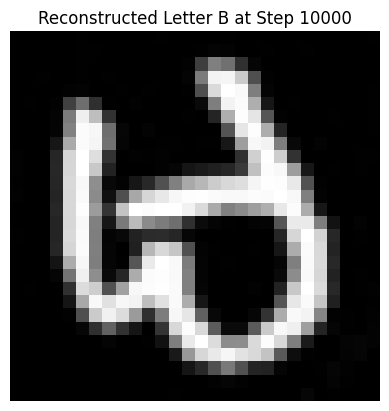

Stored 11 snapshots for letter B

Results Table for Letter B:
Step | SSIM   | MSE    | Confidence
-----|--------|--------|-----------
0    | 0.0000 | 1.0000 | 0.0000
50   | 0.0112 | 0.2780 | 1.0000
100  | 0.0370 | 0.2561 | 0.9993
200  | 0.1092 | 0.2195 | 0.9997
300  | 0.1916 | 0.1905 | 0.9997
500  | 0.3861 | 0.1398 | 1.0000
1000 | 0.7669 | 0.0541 | 1.0000
2000 | 0.9241 | 0.0127 | 1.0000
4000 | 0.9743 | 0.0021 | 1.0000
8000 | 0.9986 | 0.0000 | 1.0000
10000 | 0.9993 | 0.0000 | 1.0000
Plotting progression for letter B, 11 snapshots
Saved progression plot: /content/reconstructed_letter_B.png


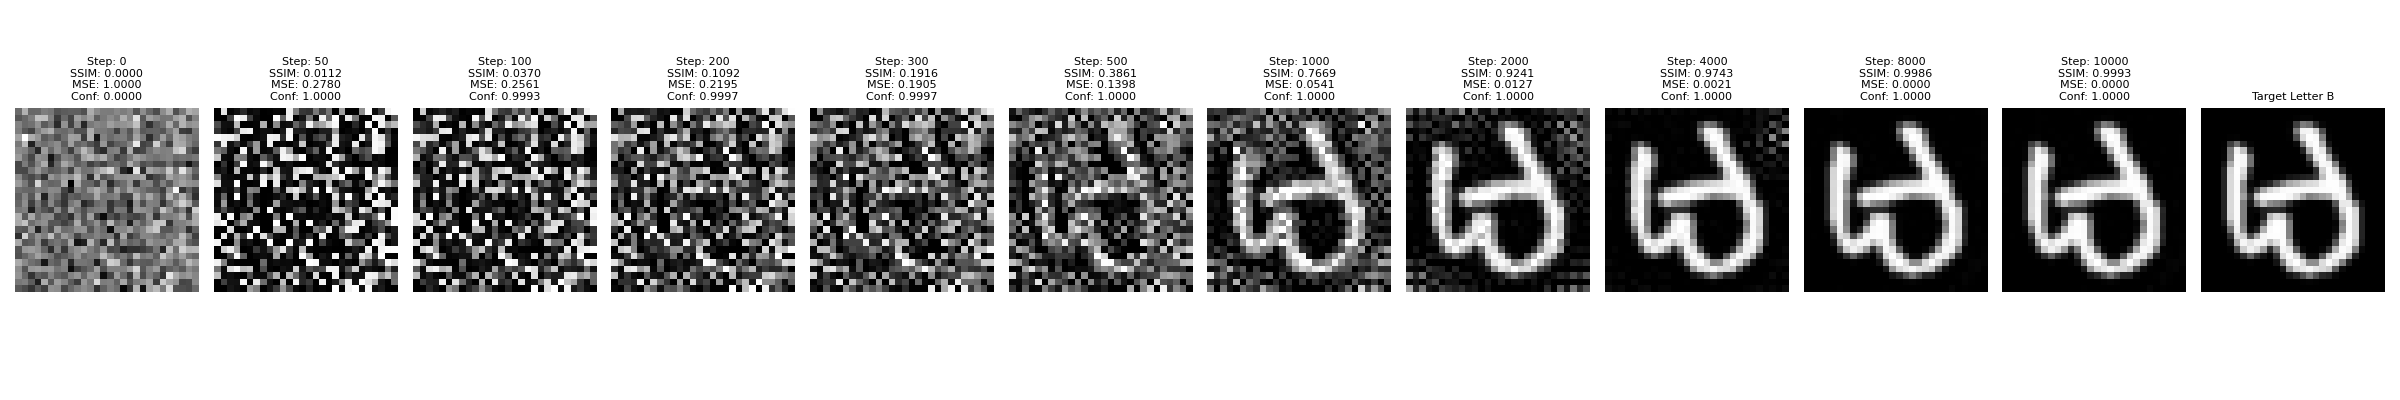

Evaluating for letter C
Step 50: SSIM=0.0606, MSE=0.2510, Conf=1.0000, Snapshot shape=(28, 28)
Step 100: SSIM=0.0662, MSE=0.2421, Conf=1.0000, Snapshot shape=(28, 28)
Step 200: SSIM=0.0803, MSE=0.2240, Conf=0.9991, Snapshot shape=(28, 28)
Step 300: SSIM=0.0987, MSE=0.2080, Conf=0.9982, Snapshot shape=(28, 28)
Step 500: SSIM=0.1364, MSE=0.1829, Conf=0.9985, Snapshot shape=(28, 28)
Step 1000: SSIM=0.2719, MSE=0.1343, Conf=0.9986, Snapshot shape=(28, 28)
Step 2000: SSIM=0.5915, MSE=0.0639, Conf=0.9995, Snapshot shape=(28, 28)
Step 4000: SSIM=0.8126, MSE=0.0249, Conf=0.9997, Snapshot shape=(28, 28)
Step 8000: SSIM=0.8690, MSE=0.0126, Conf=0.9997, Snapshot shape=(28, 28)
Step 10000: SSIM=0.8855, MSE=0.0091, Conf=0.9997, Snapshot shape=(28, 28)


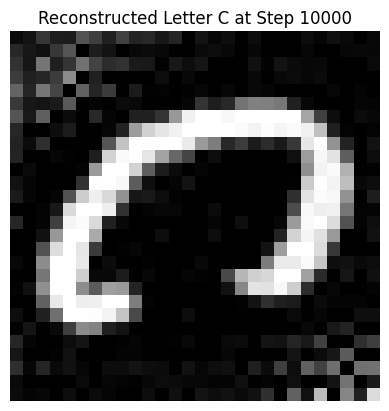

Stored 11 snapshots for letter C

Results Table for Letter C:
Step | SSIM   | MSE    | Confidence
-----|--------|--------|-----------
0    | 0.0000 | 1.0000 | 0.0000
50   | 0.0606 | 0.2510 | 1.0000
100  | 0.0662 | 0.2421 | 1.0000
200  | 0.0803 | 0.2240 | 0.9991
300  | 0.0987 | 0.2080 | 0.9982
500  | 0.1364 | 0.1829 | 0.9985
1000 | 0.2719 | 0.1343 | 0.9986
2000 | 0.5915 | 0.0639 | 0.9995
4000 | 0.8126 | 0.0249 | 0.9997
8000 | 0.8690 | 0.0126 | 0.9997
10000 | 0.8855 | 0.0091 | 0.9997
Plotting progression for letter C, 11 snapshots
Saved progression plot: /content/reconstructed_letter_C.png


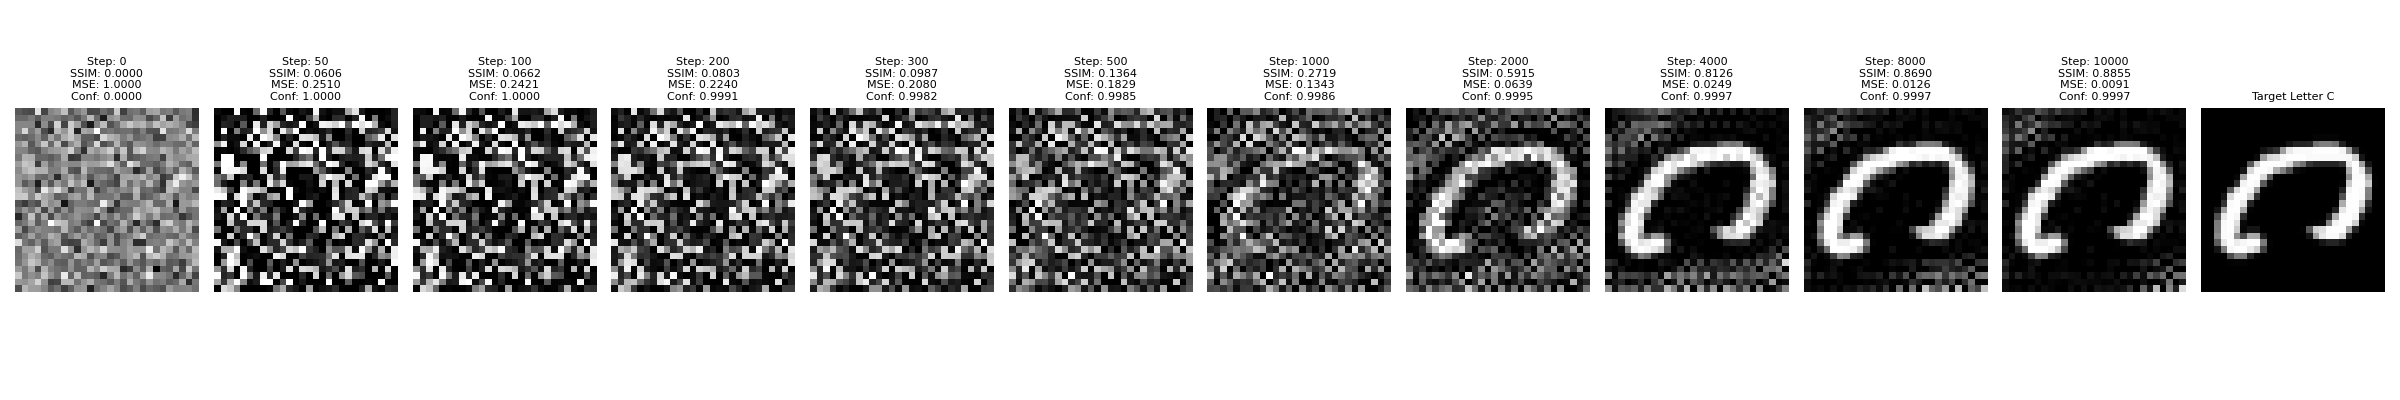

Evaluating for letter D
Step 50: SSIM=0.0474, MSE=0.2703, Conf=0.9996, Snapshot shape=(28, 28)
Step 100: SSIM=0.0565, MSE=0.2596, Conf=0.9994, Snapshot shape=(28, 28)
Step 200: SSIM=0.0797, MSE=0.2386, Conf=0.9991, Snapshot shape=(28, 28)
Step 300: SSIM=0.1076, MSE=0.2203, Conf=0.9988, Snapshot shape=(28, 28)
Step 500: SSIM=0.1705, MSE=0.1901, Conf=0.9999, Snapshot shape=(28, 28)
Step 1000: SSIM=0.3367, MSE=0.1368, Conf=0.9999, Snapshot shape=(28, 28)
Step 2000: SSIM=0.6398, MSE=0.0657, Conf=1.0000, Snapshot shape=(28, 28)
Step 4000: SSIM=0.8460, MSE=0.0177, Conf=1.0000, Snapshot shape=(28, 28)
Step 8000: SSIM=0.9611, MSE=0.0001, Conf=1.0000, Snapshot shape=(28, 28)
Step 10000: SSIM=0.9902, MSE=0.0000, Conf=1.0000, Snapshot shape=(28, 28)


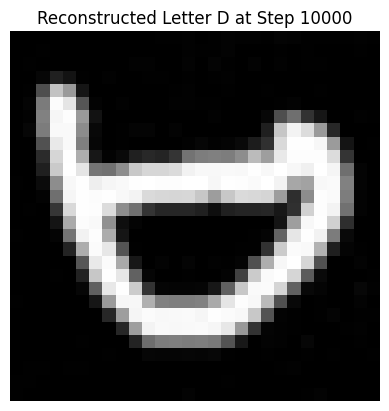

Stored 11 snapshots for letter D

Results Table for Letter D:
Step | SSIM   | MSE    | Confidence
-----|--------|--------|-----------
0    | 0.0000 | 1.0000 | 0.0000
50   | 0.0474 | 0.2703 | 0.9996
100  | 0.0565 | 0.2596 | 0.9994
200  | 0.0797 | 0.2386 | 0.9991
300  | 0.1076 | 0.2203 | 0.9988
500  | 0.1705 | 0.1901 | 0.9999
1000 | 0.3367 | 0.1368 | 0.9999
2000 | 0.6398 | 0.0657 | 1.0000
4000 | 0.8460 | 0.0177 | 1.0000
8000 | 0.9611 | 0.0001 | 1.0000
10000 | 0.9902 | 0.0000 | 1.0000
Plotting progression for letter D, 11 snapshots
Saved progression plot: /content/reconstructed_letter_D.png


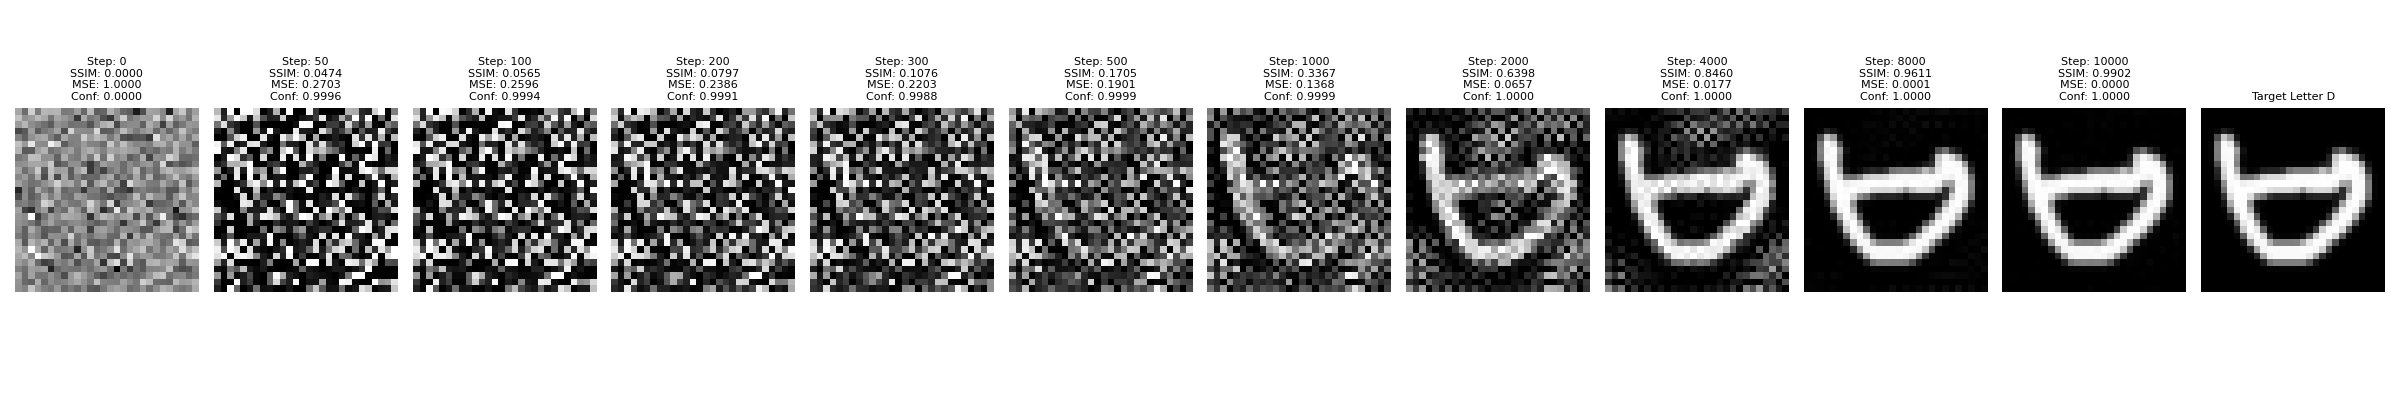

Evaluating for letter E
Step 50: SSIM=-0.0755, MSE=0.2708, Conf=1.0000, Snapshot shape=(28, 28)
Step 100: SSIM=-0.0695, MSE=0.2625, Conf=1.0000, Snapshot shape=(28, 28)
Step 200: SSIM=-0.0521, MSE=0.2443, Conf=0.9998, Snapshot shape=(28, 28)
Step 300: SSIM=-0.0312, MSE=0.2281, Conf=0.9987, Snapshot shape=(28, 28)
Step 500: SSIM=0.0179, MSE=0.2015, Conf=0.9990, Snapshot shape=(28, 28)
Step 1000: SSIM=0.2016, MSE=0.1469, Conf=0.9997, Snapshot shape=(28, 28)
Step 2000: SSIM=0.5897, MSE=0.0625, Conf=1.0000, Snapshot shape=(28, 28)
Step 4000: SSIM=0.8073, MSE=0.0153, Conf=1.0000, Snapshot shape=(28, 28)
Step 8000: SSIM=0.9469, MSE=0.0002, Conf=1.0000, Snapshot shape=(28, 28)
Step 10000: SSIM=0.9857, MSE=0.0000, Conf=1.0000, Snapshot shape=(28, 28)


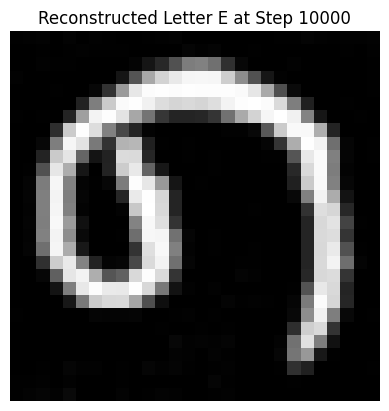

Stored 11 snapshots for letter E

Results Table for Letter E:
Step | SSIM   | MSE    | Confidence
-----|--------|--------|-----------
0    | 0.0000 | 1.0000 | 0.0000
50   | -0.0755 | 0.2708 | 1.0000
100  | -0.0695 | 0.2625 | 1.0000
200  | -0.0521 | 0.2443 | 0.9998
300  | -0.0312 | 0.2281 | 0.9987
500  | 0.0179 | 0.2015 | 0.9990
1000 | 0.2016 | 0.1469 | 0.9997
2000 | 0.5897 | 0.0625 | 1.0000
4000 | 0.8073 | 0.0153 | 1.0000
8000 | 0.9469 | 0.0002 | 1.0000
10000 | 0.9857 | 0.0000 | 1.0000
Plotting progression for letter E, 11 snapshots
Saved progression plot: /content/reconstructed_letter_E.png


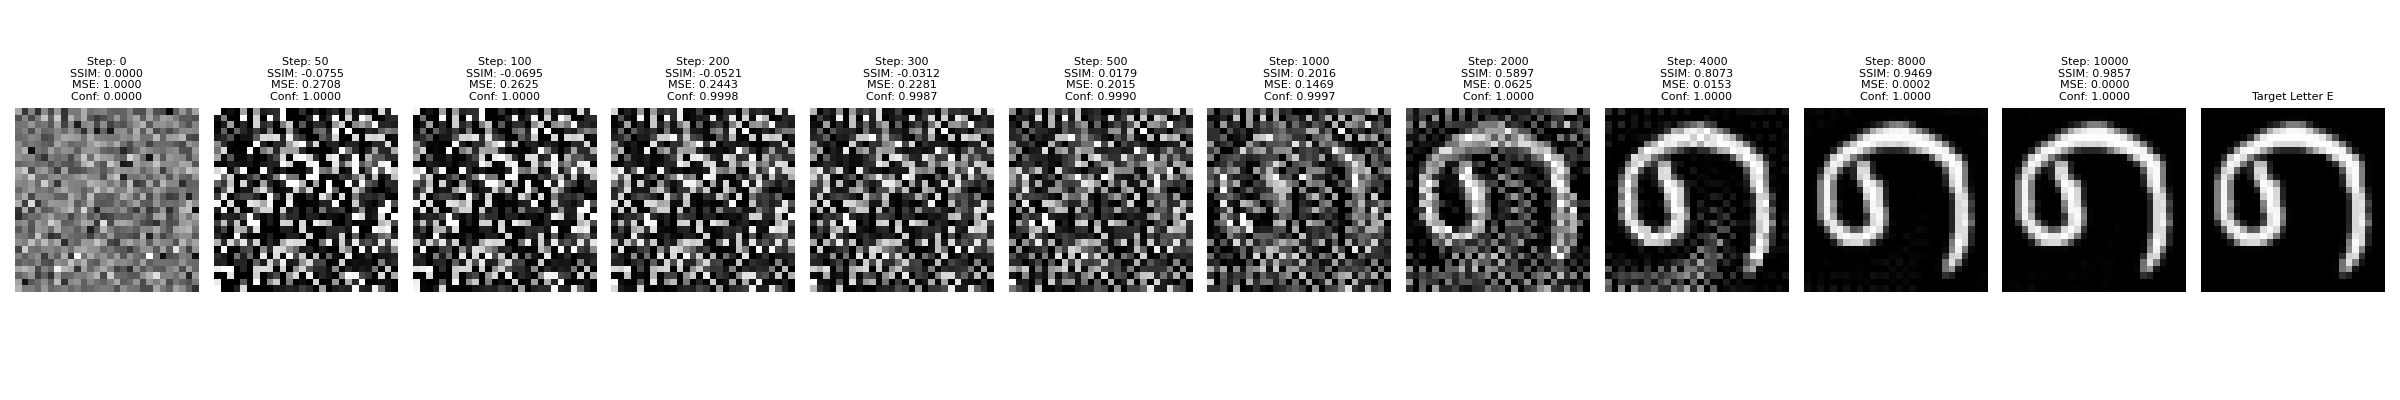

Evaluating for letter F
Step 50: SSIM=-0.0065, MSE=0.2743, Conf=1.0000, Snapshot shape=(28, 28)
Step 100: SSIM=-0.0018, MSE=0.2646, Conf=1.0000, Snapshot shape=(28, 28)
Step 200: SSIM=0.0113, MSE=0.2447, Conf=0.9997, Snapshot shape=(28, 28)
Step 300: SSIM=0.0259, MSE=0.2287, Conf=0.9989, Snapshot shape=(28, 28)
Step 500: SSIM=0.0603, MSE=0.2047, Conf=0.9990, Snapshot shape=(28, 28)
Step 1000: SSIM=0.2178, MSE=0.1532, Conf=0.9997, Snapshot shape=(28, 28)
Step 2000: SSIM=0.5252, MSE=0.0777, Conf=0.9998, Snapshot shape=(28, 28)
Step 4000: SSIM=0.7284, MSE=0.0301, Conf=0.9998, Snapshot shape=(28, 28)
Step 8000: SSIM=0.8549, MSE=0.0089, Conf=0.9999, Snapshot shape=(28, 28)
Step 10000: SSIM=0.9201, MSE=0.0004, Conf=0.9999, Snapshot shape=(28, 28)


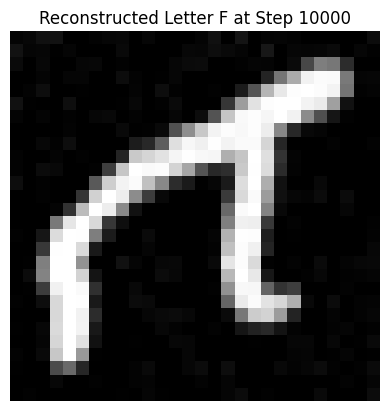

Stored 11 snapshots for letter F

Results Table for Letter F:
Step | SSIM   | MSE    | Confidence
-----|--------|--------|-----------
0    | 0.0000 | 1.0000 | 0.0000
50   | -0.0065 | 0.2743 | 1.0000
100  | -0.0018 | 0.2646 | 1.0000
200  | 0.0113 | 0.2447 | 0.9997
300  | 0.0259 | 0.2287 | 0.9989
500  | 0.0603 | 0.2047 | 0.9990
1000 | 0.2178 | 0.1532 | 0.9997
2000 | 0.5252 | 0.0777 | 0.9998
4000 | 0.7284 | 0.0301 | 0.9998
8000 | 0.8549 | 0.0089 | 0.9999
10000 | 0.9201 | 0.0004 | 0.9999
Plotting progression for letter F, 11 snapshots
Saved progression plot: /content/reconstructed_letter_F.png


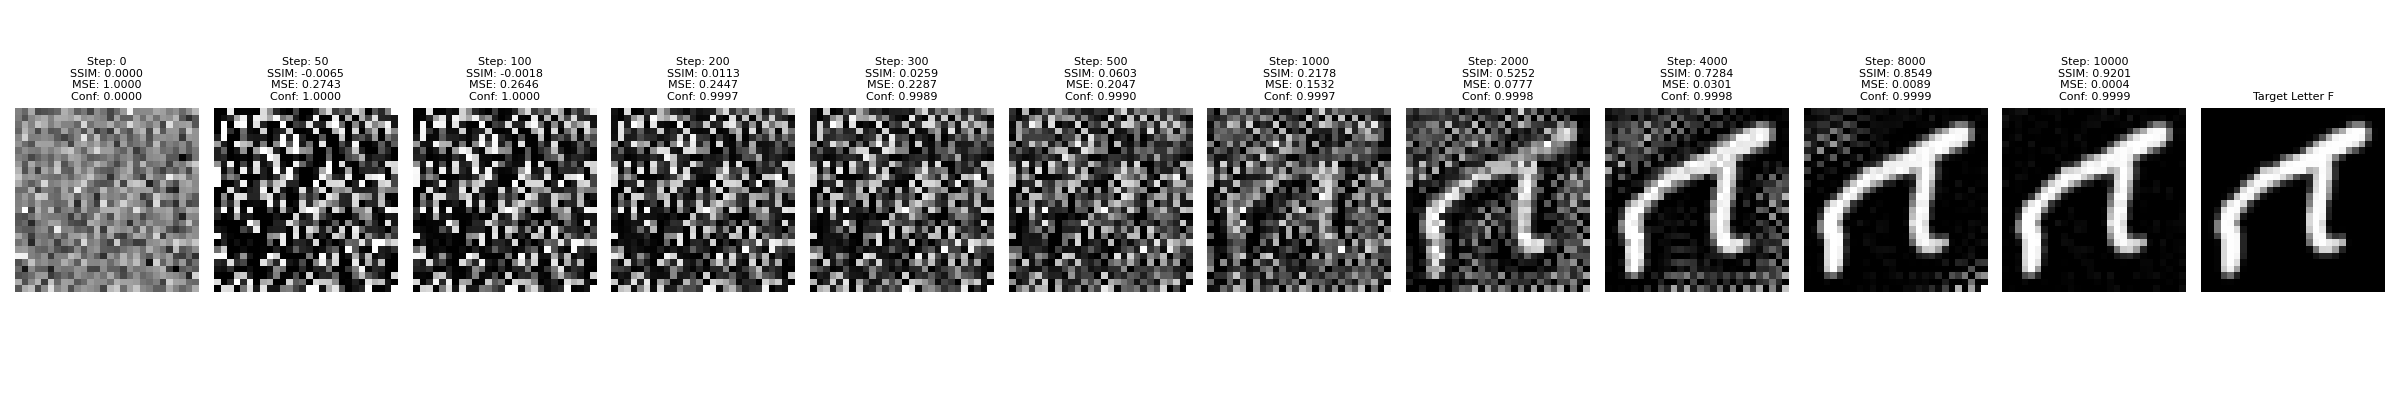

Evaluating for letter G
Step 50: SSIM=-0.0214, MSE=0.3201, Conf=1.0000, Snapshot shape=(28, 28)
Step 100: SSIM=-0.0157, MSE=0.3058, Conf=1.0000, Snapshot shape=(28, 28)
Step 200: SSIM=0.0021, MSE=0.2806, Conf=0.9996, Snapshot shape=(28, 28)
Step 300: SSIM=0.0270, MSE=0.2606, Conf=0.9996, Snapshot shape=(28, 28)
Step 500: SSIM=0.1074, MSE=0.2257, Conf=0.9997, Snapshot shape=(28, 28)
Step 1000: SSIM=0.3740, MSE=0.1493, Conf=0.9998, Snapshot shape=(28, 28)
Step 2000: SSIM=0.7216, MSE=0.0618, Conf=0.9998, Snapshot shape=(28, 28)
Step 4000: SSIM=0.9444, MSE=0.0095, Conf=1.0000, Snapshot shape=(28, 28)
Step 8000: SSIM=0.9961, MSE=0.0002, Conf=1.0000, Snapshot shape=(28, 28)
Step 10000: SSIM=0.9989, MSE=0.0002, Conf=1.0000, Snapshot shape=(28, 28)


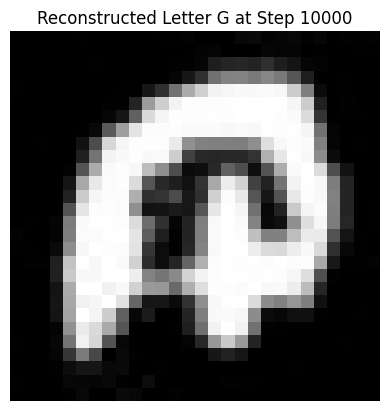

Stored 11 snapshots for letter G

Results Table for Letter G:
Step | SSIM   | MSE    | Confidence
-----|--------|--------|-----------
0    | 0.0000 | 1.0000 | 0.0000
50   | -0.0214 | 0.3201 | 1.0000
100  | -0.0157 | 0.3058 | 1.0000
200  | 0.0021 | 0.2806 | 0.9996
300  | 0.0270 | 0.2606 | 0.9996
500  | 0.1074 | 0.2257 | 0.9997
1000 | 0.3740 | 0.1493 | 0.9998
2000 | 0.7216 | 0.0618 | 0.9998
4000 | 0.9444 | 0.0095 | 1.0000
8000 | 0.9961 | 0.0002 | 1.0000
10000 | 0.9989 | 0.0002 | 1.0000
Plotting progression for letter G, 11 snapshots
Saved progression plot: /content/reconstructed_letter_G.png


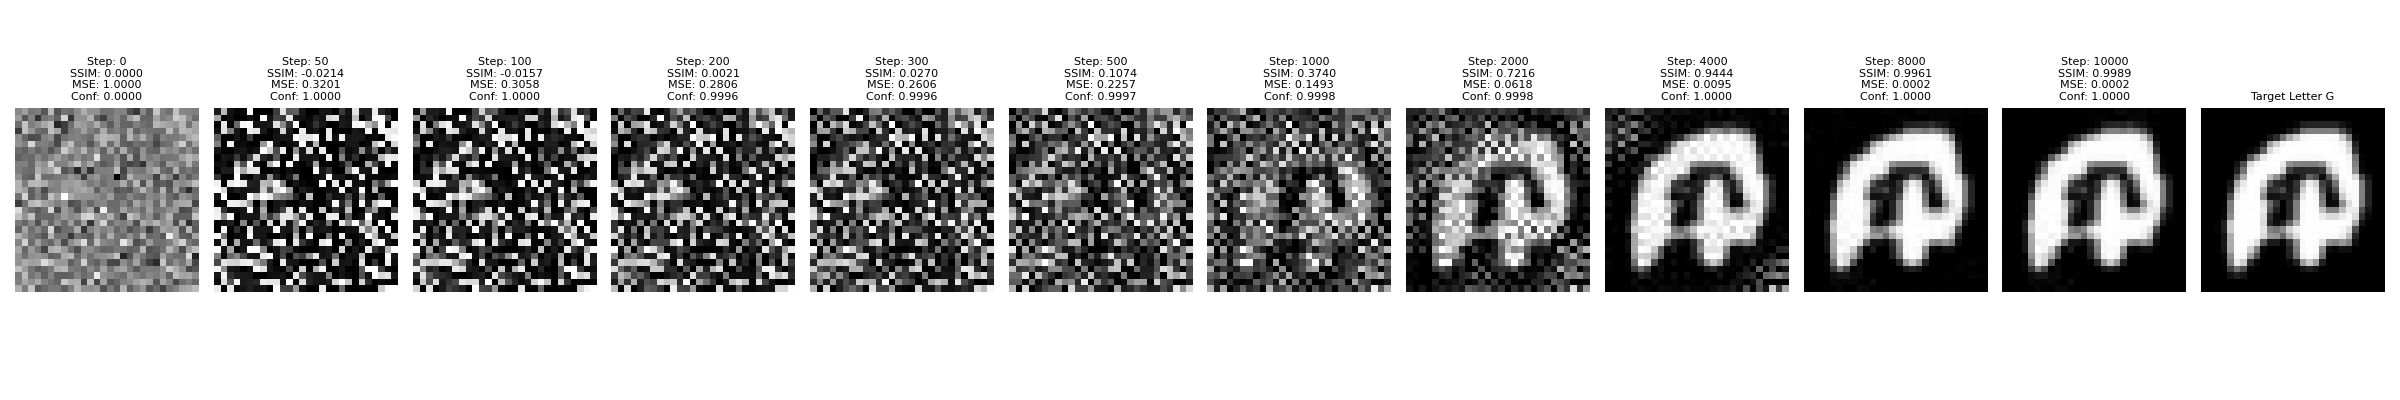

Evaluating for letter H
Step 50: SSIM=0.0766, MSE=0.2489, Conf=0.9998, Snapshot shape=(28, 28)
Step 100: SSIM=0.0789, MSE=0.2428, Conf=0.9997, Snapshot shape=(28, 28)
Step 200: SSIM=0.0860, MSE=0.2291, Conf=0.9979, Snapshot shape=(28, 28)
Step 300: SSIM=0.0949, MSE=0.2161, Conf=0.9978, Snapshot shape=(28, 28)
Step 500: SSIM=0.1147, MSE=0.1953, Conf=0.9983, Snapshot shape=(28, 28)
Step 1000: SSIM=0.1908, MSE=0.1578, Conf=0.9987, Snapshot shape=(28, 28)
Step 2000: SSIM=0.4191, MSE=0.0968, Conf=0.9999, Snapshot shape=(28, 28)
Step 4000: SSIM=0.5640, MSE=0.0522, Conf=0.9999, Snapshot shape=(28, 28)
Step 8000: SSIM=0.6051, MSE=0.0326, Conf=1.0000, Snapshot shape=(28, 28)
Step 10000: SSIM=0.6521, MSE=0.0238, Conf=1.0000, Snapshot shape=(28, 28)


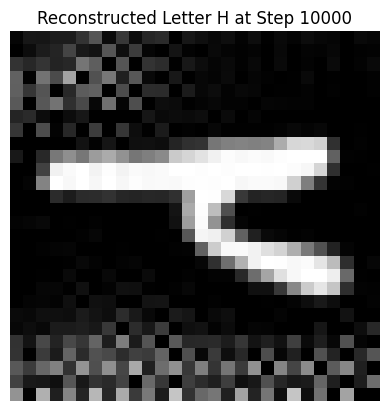

Stored 11 snapshots for letter H

Results Table for Letter H:
Step | SSIM   | MSE    | Confidence
-----|--------|--------|-----------
0    | 0.0000 | 1.0000 | 0.0000
50   | 0.0766 | 0.2489 | 0.9998
100  | 0.0789 | 0.2428 | 0.9997
200  | 0.0860 | 0.2291 | 0.9979
300  | 0.0949 | 0.2161 | 0.9978
500  | 0.1147 | 0.1953 | 0.9983
1000 | 0.1908 | 0.1578 | 0.9987
2000 | 0.4191 | 0.0968 | 0.9999
4000 | 0.5640 | 0.0522 | 0.9999
8000 | 0.6051 | 0.0326 | 1.0000
10000 | 0.6521 | 0.0238 | 1.0000
Plotting progression for letter H, 11 snapshots
Saved progression plot: /content/reconstructed_letter_H.png


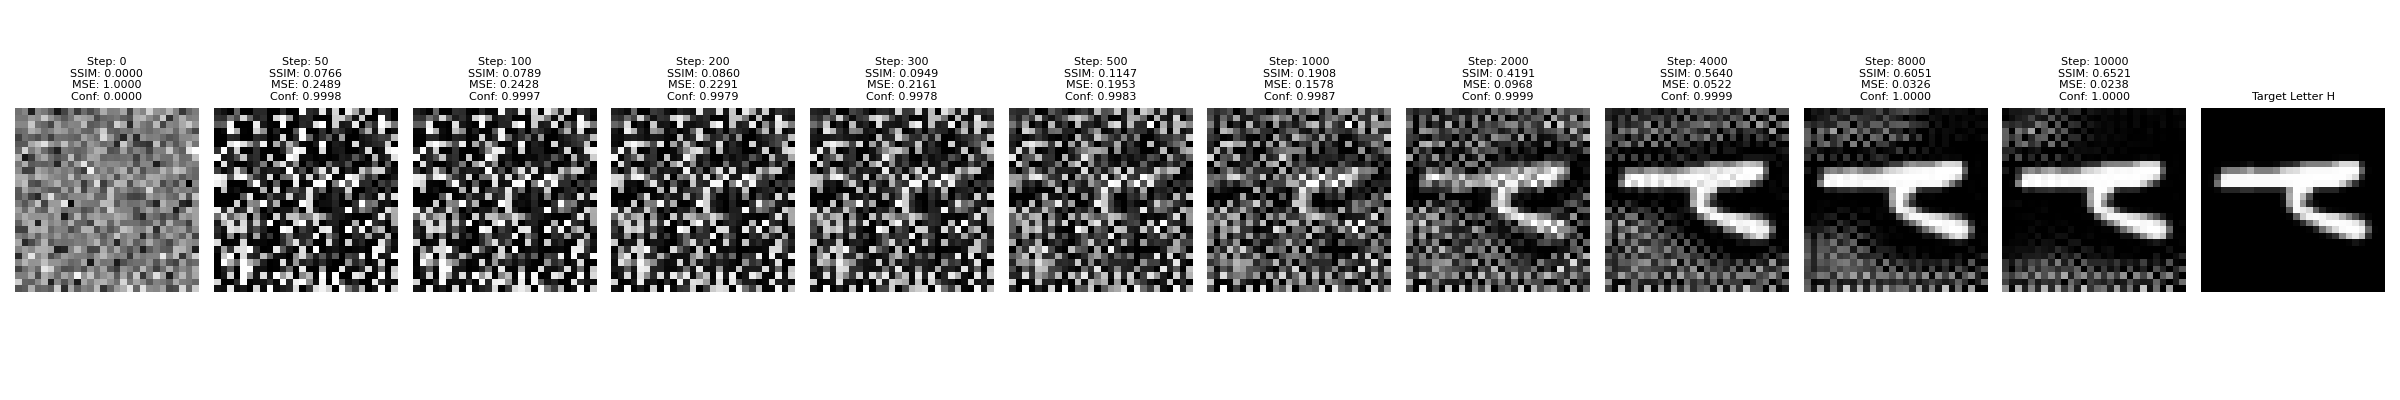

Evaluating for letter I
Step 50: SSIM=-0.0059, MSE=0.2413, Conf=0.9999, Snapshot shape=(28, 28)
Step 100: SSIM=-0.0055, MSE=0.2335, Conf=0.9999, Snapshot shape=(28, 28)
Step 200: SSIM=-0.0034, MSE=0.2173, Conf=0.9988, Snapshot shape=(28, 28)
Step 300: SSIM=-0.0019, MSE=0.2039, Conf=0.9975, Snapshot shape=(28, 28)
Step 500: SSIM=0.0049, MSE=0.1834, Conf=0.9975, Snapshot shape=(28, 28)
Step 1000: SSIM=0.0232, MSE=0.1546, Conf=0.9976, Snapshot shape=(28, 28)
Step 2000: SSIM=0.1028, MSE=0.1194, Conf=0.9983, Snapshot shape=(28, 28)
Step 4000: SSIM=0.2611, MSE=0.0793, Conf=0.9985, Snapshot shape=(28, 28)
Step 8000: SSIM=0.3760, MSE=0.0564, Conf=0.9986, Snapshot shape=(28, 28)
Step 10000: SSIM=0.3863, MSE=0.0532, Conf=0.9986, Snapshot shape=(28, 28)


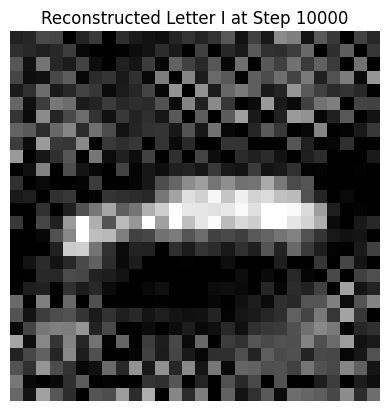

Stored 11 snapshots for letter I

Results Table for Letter I:
Step | SSIM   | MSE    | Confidence
-----|--------|--------|-----------
0    | 0.0000 | 1.0000 | 0.0000
50   | -0.0059 | 0.2413 | 0.9999
100  | -0.0055 | 0.2335 | 0.9999
200  | -0.0034 | 0.2173 | 0.9988
300  | -0.0019 | 0.2039 | 0.9975
500  | 0.0049 | 0.1834 | 0.9975
1000 | 0.0232 | 0.1546 | 0.9976
2000 | 0.1028 | 0.1194 | 0.9983
4000 | 0.2611 | 0.0793 | 0.9985
8000 | 0.3760 | 0.0564 | 0.9986
10000 | 0.3863 | 0.0532 | 0.9986
Plotting progression for letter I, 11 snapshots
Saved progression plot: /content/reconstructed_letter_I.png


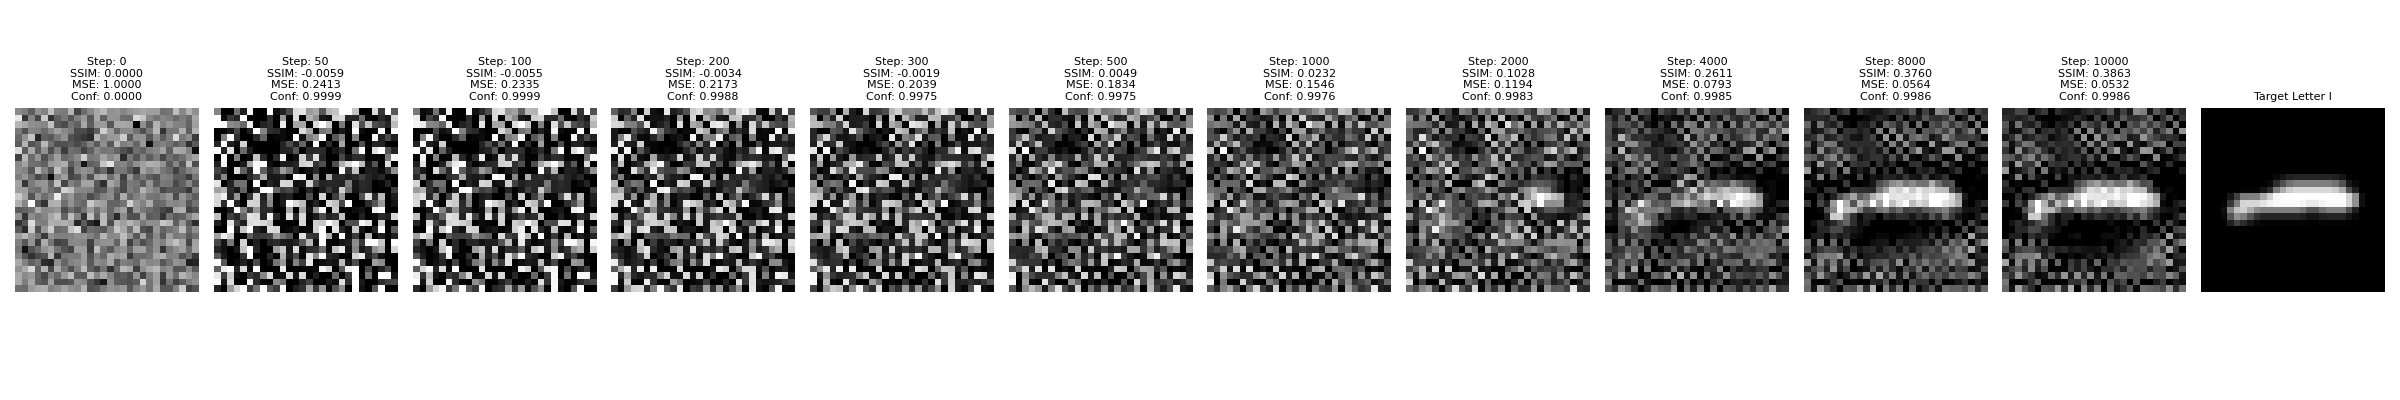

Evaluating for letter J
Step 50: SSIM=-0.0088, MSE=0.2536, Conf=0.9993, Snapshot shape=(28, 28)
Step 100: SSIM=-0.0029, MSE=0.2447, Conf=0.9995, Snapshot shape=(28, 28)
Step 200: SSIM=0.0142, MSE=0.2259, Conf=0.9985, Snapshot shape=(28, 28)
Step 300: SSIM=0.0333, MSE=0.2100, Conf=0.9982, Snapshot shape=(28, 28)
Step 500: SSIM=0.0825, MSE=0.1843, Conf=0.9987, Snapshot shape=(28, 28)
Step 1000: SSIM=0.2392, MSE=0.1303, Conf=0.9996, Snapshot shape=(28, 28)
Step 2000: SSIM=0.5088, MSE=0.0616, Conf=0.9996, Snapshot shape=(28, 28)
Step 4000: SSIM=0.6564, MSE=0.0234, Conf=0.9998, Snapshot shape=(28, 28)
Step 8000: SSIM=0.7776, MSE=0.0075, Conf=0.9999, Snapshot shape=(28, 28)
Step 10000: SSIM=0.7977, MSE=0.0051, Conf=0.9999, Snapshot shape=(28, 28)


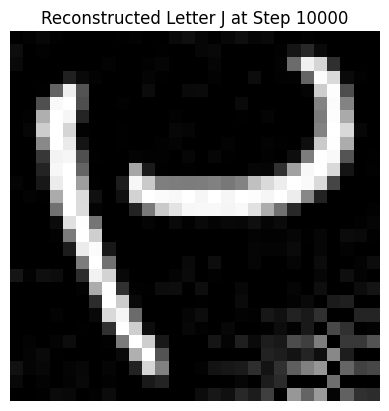

Stored 11 snapshots for letter J

Results Table for Letter J:
Step | SSIM   | MSE    | Confidence
-----|--------|--------|-----------
0    | 0.0000 | 1.0000 | 0.0000
50   | -0.0088 | 0.2536 | 0.9993
100  | -0.0029 | 0.2447 | 0.9995
200  | 0.0142 | 0.2259 | 0.9985
300  | 0.0333 | 0.2100 | 0.9982
500  | 0.0825 | 0.1843 | 0.9987
1000 | 0.2392 | 0.1303 | 0.9996
2000 | 0.5088 | 0.0616 | 0.9996
4000 | 0.6564 | 0.0234 | 0.9998
8000 | 0.7776 | 0.0075 | 0.9999
10000 | 0.7977 | 0.0051 | 0.9999
Plotting progression for letter J, 11 snapshots
Saved progression plot: /content/reconstructed_letter_J.png


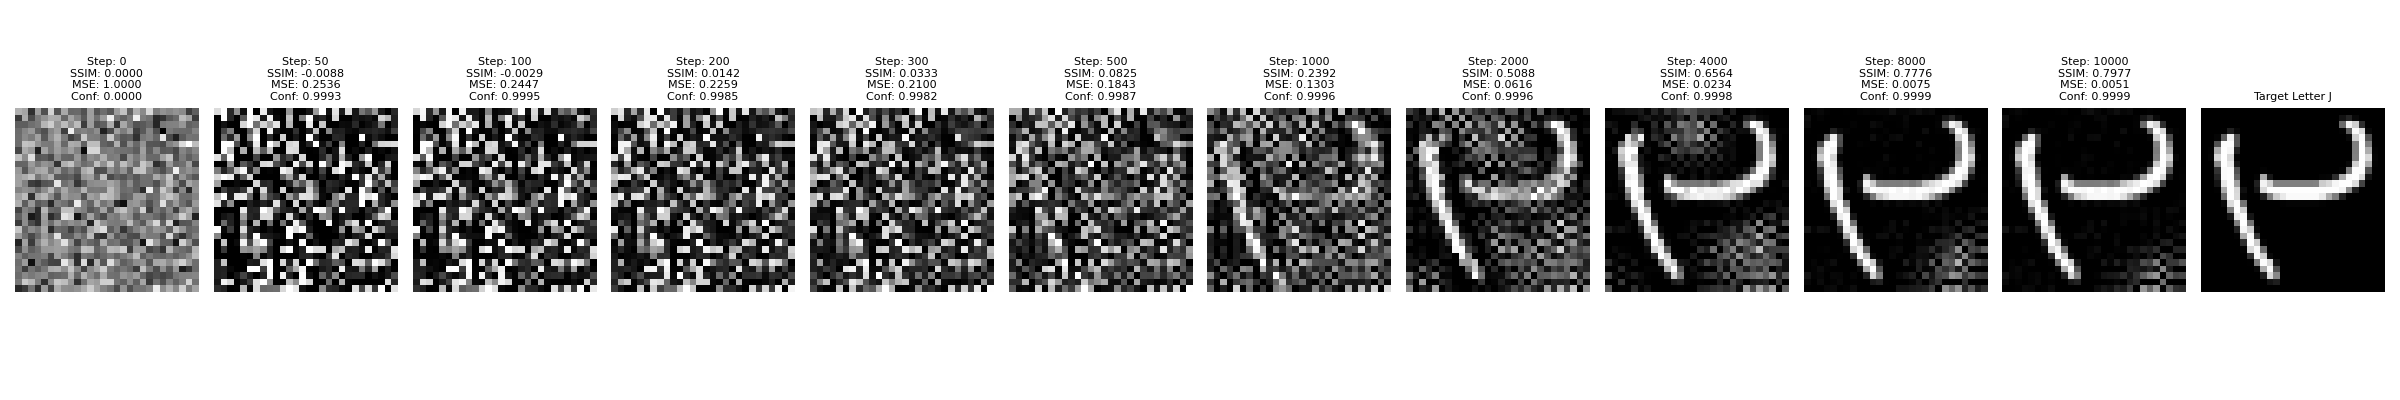

Evaluating for letter K
Step 50: SSIM=0.0318, MSE=0.2584, Conf=1.0000, Snapshot shape=(28, 28)
Step 100: SSIM=0.0439, MSE=0.2447, Conf=1.0000, Snapshot shape=(28, 28)
Step 200: SSIM=0.0719, MSE=0.2212, Conf=1.0000, Snapshot shape=(28, 28)
Step 300: SSIM=0.1043, MSE=0.2035, Conf=0.9999, Snapshot shape=(28, 28)
Step 500: SSIM=0.1763, MSE=0.1759, Conf=1.0000, Snapshot shape=(28, 28)
Step 1000: SSIM=0.3468, MSE=0.1239, Conf=1.0000, Snapshot shape=(28, 28)
Step 2000: SSIM=0.6220, MSE=0.0569, Conf=1.0000, Snapshot shape=(28, 28)
Step 4000: SSIM=0.7321, MSE=0.0255, Conf=1.0000, Snapshot shape=(28, 28)
Step 8000: SSIM=0.8848, MSE=0.0004, Conf=1.0000, Snapshot shape=(28, 28)
Step 10000: SSIM=0.9820, MSE=0.0000, Conf=1.0000, Snapshot shape=(28, 28)


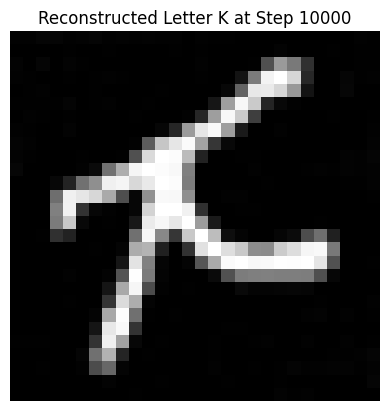

Stored 11 snapshots for letter K

Results Table for Letter K:
Step | SSIM   | MSE    | Confidence
-----|--------|--------|-----------
0    | 0.0000 | 1.0000 | 0.0000
50   | 0.0318 | 0.2584 | 1.0000
100  | 0.0439 | 0.2447 | 1.0000
200  | 0.0719 | 0.2212 | 1.0000
300  | 0.1043 | 0.2035 | 0.9999
500  | 0.1763 | 0.1759 | 1.0000
1000 | 0.3468 | 0.1239 | 1.0000
2000 | 0.6220 | 0.0569 | 1.0000
4000 | 0.7321 | 0.0255 | 1.0000
8000 | 0.8848 | 0.0004 | 1.0000
10000 | 0.9820 | 0.0000 | 1.0000
Plotting progression for letter K, 11 snapshots
Saved progression plot: /content/reconstructed_letter_K.png


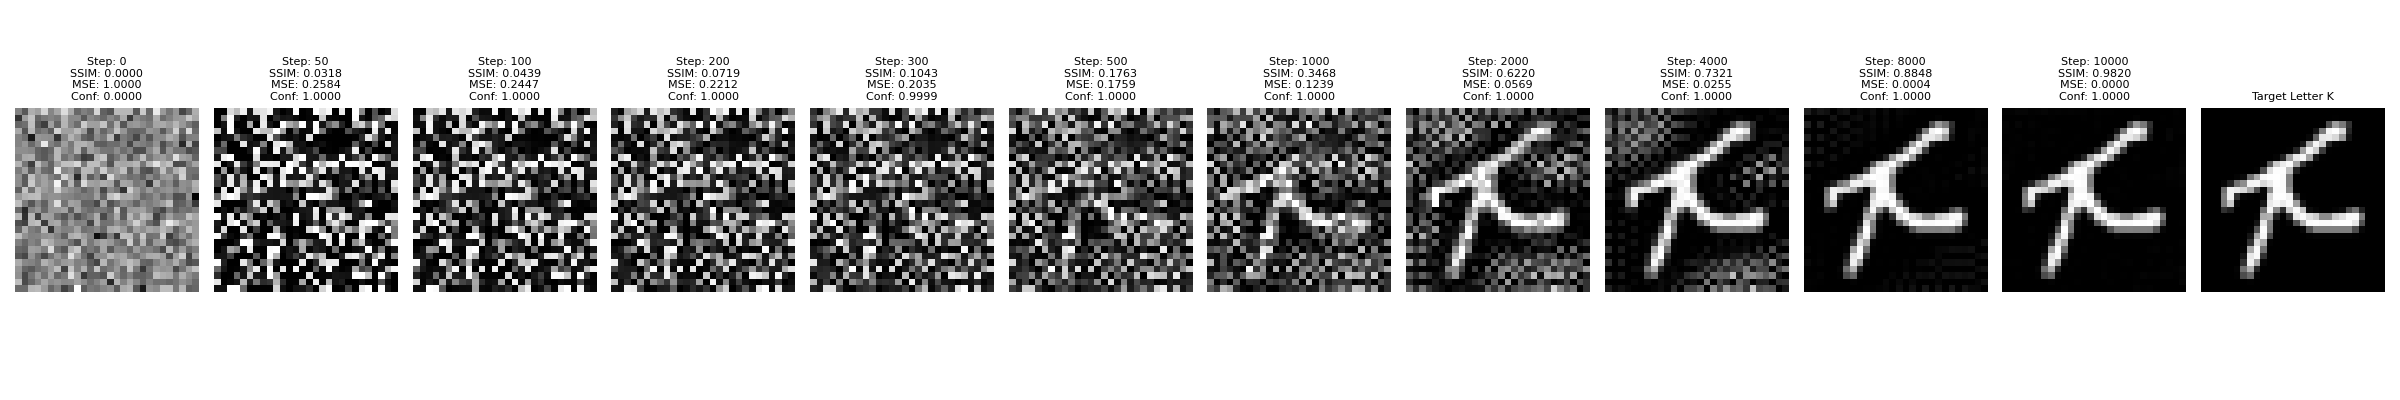

Evaluating for letter L
Step 50: SSIM=-0.0302, MSE=0.2587, Conf=0.9997, Snapshot shape=(28, 28)
Step 100: SSIM=-0.0296, MSE=0.2518, Conf=0.9996, Snapshot shape=(28, 28)
Step 200: SSIM=-0.0277, MSE=0.2374, Conf=0.9980, Snapshot shape=(28, 28)
Step 300: SSIM=-0.0248, MSE=0.2247, Conf=0.9978, Snapshot shape=(28, 28)
Step 500: SSIM=-0.0194, MSE=0.2058, Conf=0.9972, Snapshot shape=(28, 28)
Step 1000: SSIM=-0.0074, MSE=0.1789, Conf=0.9972, Snapshot shape=(28, 28)
Step 2000: SSIM=0.0436, MSE=0.1481, Conf=0.9981, Snapshot shape=(28, 28)
Step 4000: SSIM=0.3619, MSE=0.0807, Conf=0.9982, Snapshot shape=(28, 28)
Step 8000: SSIM=0.4939, MSE=0.0503, Conf=0.9987, Snapshot shape=(28, 28)
Step 10000: SSIM=0.4958, MSE=0.0493, Conf=0.9988, Snapshot shape=(28, 28)


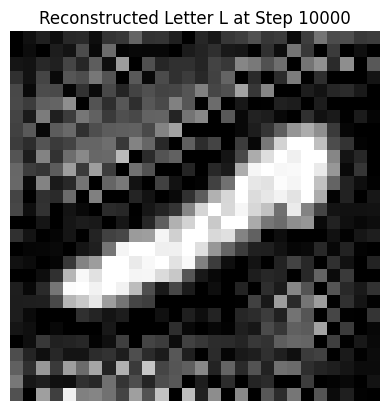

Stored 11 snapshots for letter L

Results Table for Letter L:
Step | SSIM   | MSE    | Confidence
-----|--------|--------|-----------
0    | 0.0000 | 1.0000 | 0.0000
50   | -0.0302 | 0.2587 | 0.9997
100  | -0.0296 | 0.2518 | 0.9996
200  | -0.0277 | 0.2374 | 0.9980
300  | -0.0248 | 0.2247 | 0.9978
500  | -0.0194 | 0.2058 | 0.9972
1000 | -0.0074 | 0.1789 | 0.9972
2000 | 0.0436 | 0.1481 | 0.9981
4000 | 0.3619 | 0.0807 | 0.9982
8000 | 0.4939 | 0.0503 | 0.9987
10000 | 0.4958 | 0.0493 | 0.9988
Plotting progression for letter L, 11 snapshots
Saved progression plot: /content/reconstructed_letter_L.png


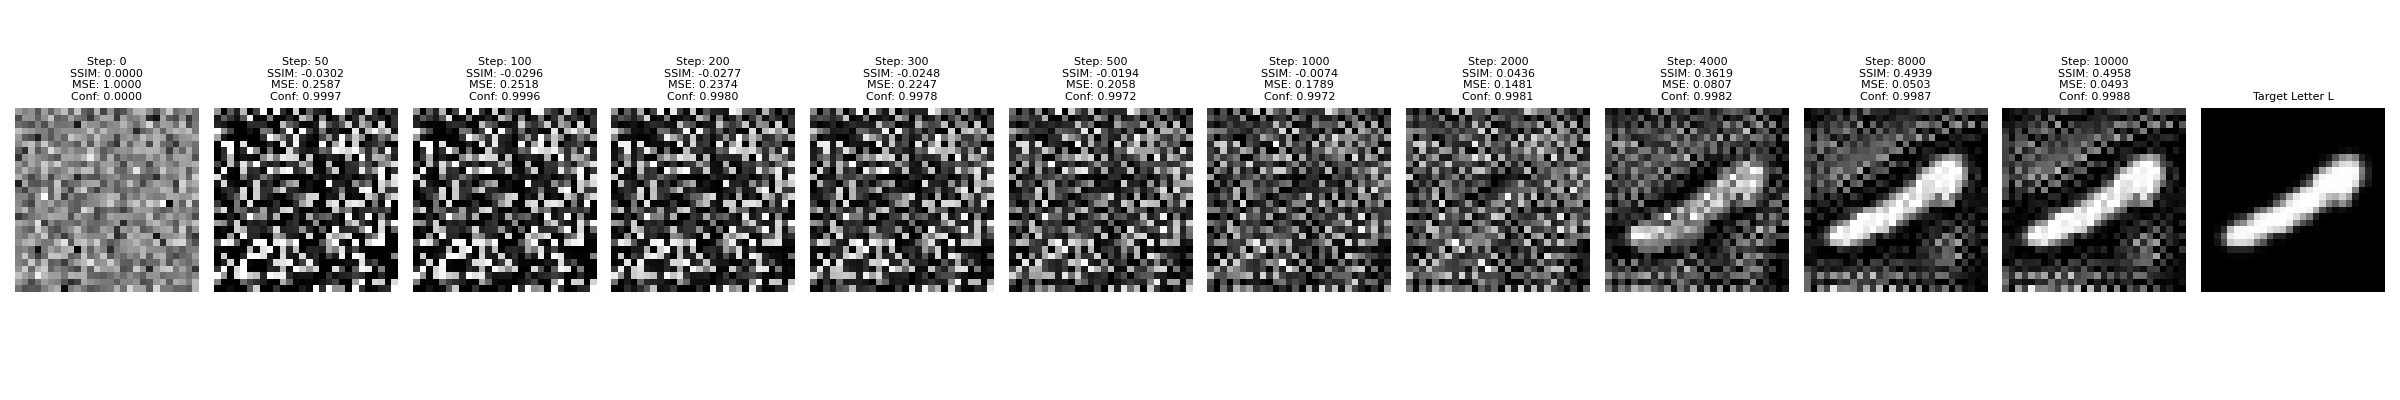

Evaluating for letter M
Step 50: SSIM=-0.0242, MSE=0.2766, Conf=1.0000, Snapshot shape=(28, 28)
Step 100: SSIM=-0.0149, MSE=0.2613, Conf=0.9999, Snapshot shape=(28, 28)
Step 200: SSIM=0.0091, MSE=0.2361, Conf=0.9994, Snapshot shape=(28, 28)
Step 300: SSIM=0.0372, MSE=0.2168, Conf=0.9993, Snapshot shape=(28, 28)
Step 500: SSIM=0.0994, MSE=0.1865, Conf=0.9994, Snapshot shape=(28, 28)
Step 1000: SSIM=0.2871, MSE=0.1274, Conf=0.9998, Snapshot shape=(28, 28)
Step 2000: SSIM=0.4967, MSE=0.0643, Conf=1.0000, Snapshot shape=(28, 28)
Step 4000: SSIM=0.5525, MSE=0.0387, Conf=1.0000, Snapshot shape=(28, 28)
Step 8000: SSIM=0.5872, MSE=0.0263, Conf=1.0000, Snapshot shape=(28, 28)
Step 10000: SSIM=0.6065, MSE=0.0236, Conf=1.0000, Snapshot shape=(28, 28)


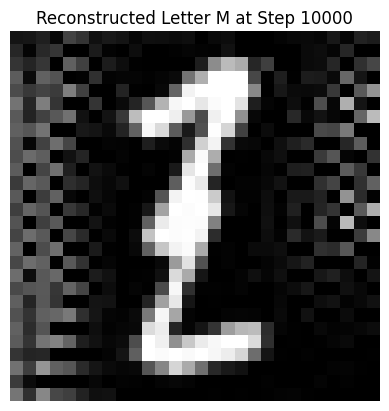

Stored 11 snapshots for letter M

Results Table for Letter M:
Step | SSIM   | MSE    | Confidence
-----|--------|--------|-----------
0    | 0.0000 | 1.0000 | 0.0000
50   | -0.0242 | 0.2766 | 1.0000
100  | -0.0149 | 0.2613 | 0.9999
200  | 0.0091 | 0.2361 | 0.9994
300  | 0.0372 | 0.2168 | 0.9993
500  | 0.0994 | 0.1865 | 0.9994
1000 | 0.2871 | 0.1274 | 0.9998
2000 | 0.4967 | 0.0643 | 1.0000
4000 | 0.5525 | 0.0387 | 1.0000
8000 | 0.5872 | 0.0263 | 1.0000
10000 | 0.6065 | 0.0236 | 1.0000
Plotting progression for letter M, 11 snapshots
Saved progression plot: /content/reconstructed_letter_M.png


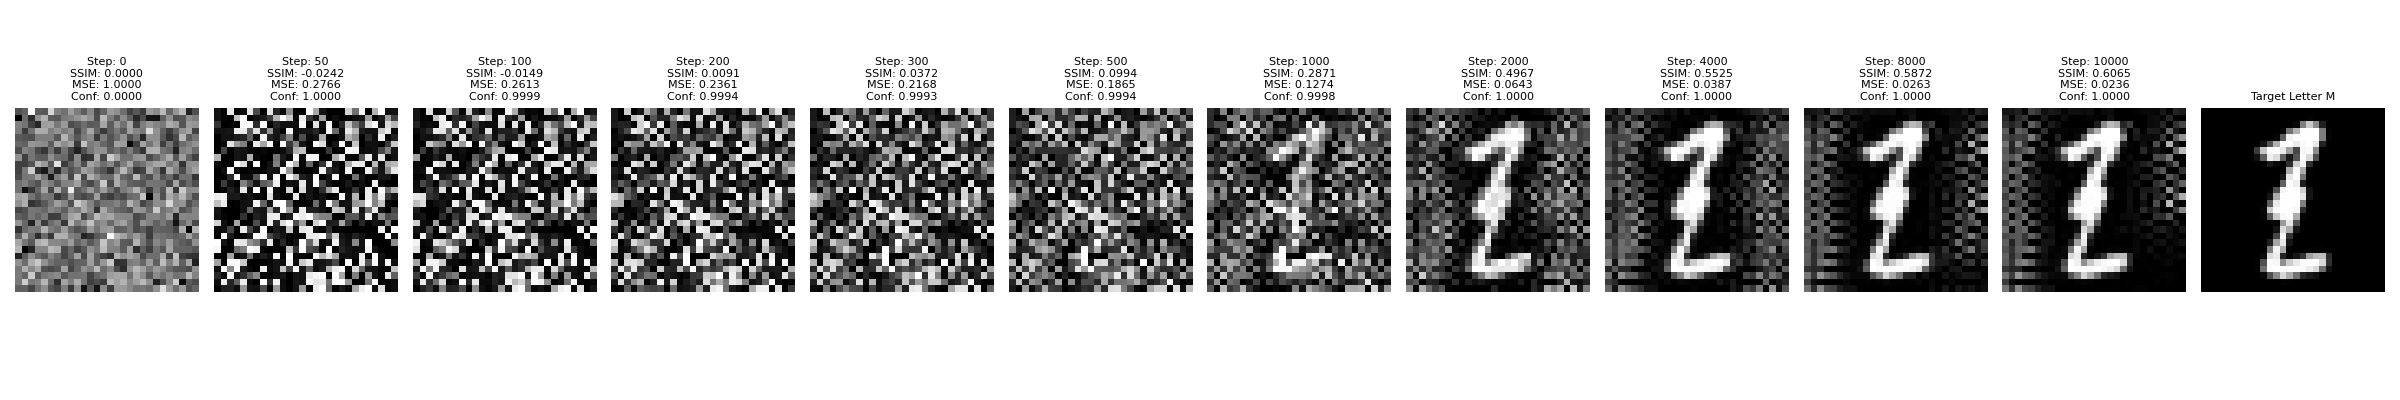

Evaluating for letter N
Step 50: SSIM=0.0249, MSE=0.2403, Conf=0.9937, Snapshot shape=(28, 28)
Step 100: SSIM=0.0276, MSE=0.2330, Conf=0.9968, Snapshot shape=(28, 28)
Step 200: SSIM=0.0387, MSE=0.2169, Conf=0.9957, Snapshot shape=(28, 28)
Step 300: SSIM=0.0546, MSE=0.2024, Conf=0.9963, Snapshot shape=(28, 28)
Step 500: SSIM=0.0943, MSE=0.1794, Conf=0.9967, Snapshot shape=(28, 28)
Step 1000: SSIM=0.2324, MSE=0.1354, Conf=0.9976, Snapshot shape=(28, 28)
Step 2000: SSIM=0.5093, MSE=0.0716, Conf=0.9992, Snapshot shape=(28, 28)
Step 4000: SSIM=0.7198, MSE=0.0243, Conf=0.9996, Snapshot shape=(28, 28)
Step 8000: SSIM=0.7874, MSE=0.0122, Conf=0.9997, Snapshot shape=(28, 28)
Step 10000: SSIM=0.7996, MSE=0.0084, Conf=0.9997, Snapshot shape=(28, 28)


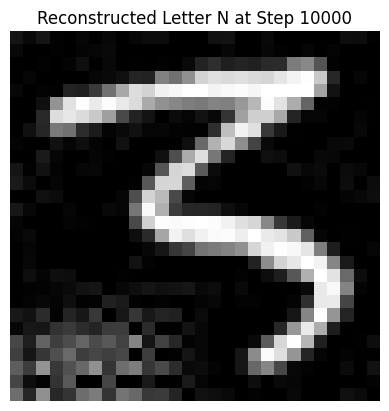

Stored 11 snapshots for letter N

Results Table for Letter N:
Step | SSIM   | MSE    | Confidence
-----|--------|--------|-----------
0    | 0.0000 | 1.0000 | 0.0000
50   | 0.0249 | 0.2403 | 0.9937
100  | 0.0276 | 0.2330 | 0.9968
200  | 0.0387 | 0.2169 | 0.9957
300  | 0.0546 | 0.2024 | 0.9963
500  | 0.0943 | 0.1794 | 0.9967
1000 | 0.2324 | 0.1354 | 0.9976
2000 | 0.5093 | 0.0716 | 0.9992
4000 | 0.7198 | 0.0243 | 0.9996
8000 | 0.7874 | 0.0122 | 0.9997
10000 | 0.7996 | 0.0084 | 0.9997
Plotting progression for letter N, 11 snapshots
Saved progression plot: /content/reconstructed_letter_N.png


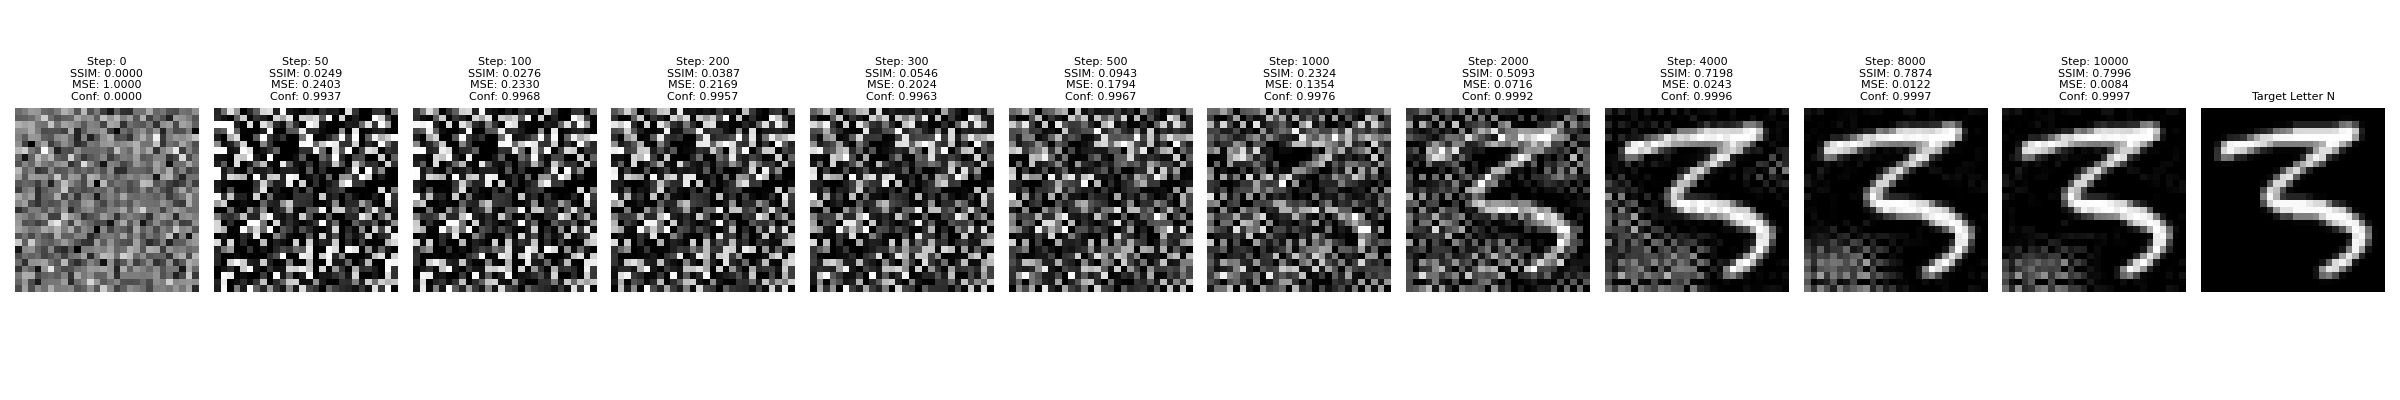

Evaluating for letter O
Step 50: SSIM=0.0233, MSE=0.2583, Conf=0.9960, Snapshot shape=(28, 28)
Step 100: SSIM=0.0290, MSE=0.2511, Conf=0.9989, Snapshot shape=(28, 28)
Step 200: SSIM=0.0402, MSE=0.2364, Conf=0.9979, Snapshot shape=(28, 28)
Step 300: SSIM=0.0537, MSE=0.2233, Conf=0.9977, Snapshot shape=(28, 28)
Step 500: SSIM=0.0870, MSE=0.2024, Conf=0.9976, Snapshot shape=(28, 28)
Step 1000: SSIM=0.1995, MSE=0.1634, Conf=0.9983, Snapshot shape=(28, 28)
Step 2000: SSIM=0.5009, MSE=0.0941, Conf=0.9993, Snapshot shape=(28, 28)
Step 4000: SSIM=0.8643, MSE=0.0166, Conf=1.0000, Snapshot shape=(28, 28)
Step 8000: SSIM=0.9921, MSE=0.0002, Conf=1.0000, Snapshot shape=(28, 28)
Step 10000: SSIM=0.9974, MSE=0.0001, Conf=1.0000, Snapshot shape=(28, 28)


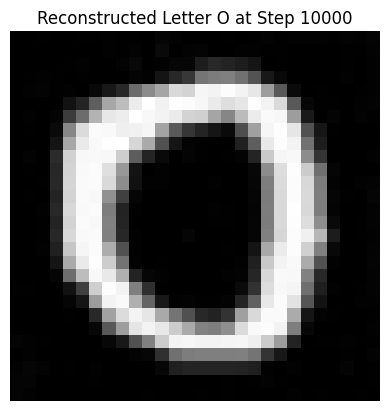

Stored 11 snapshots for letter O

Results Table for Letter O:
Step | SSIM   | MSE    | Confidence
-----|--------|--------|-----------
0    | 0.0000 | 1.0000 | 0.0000
50   | 0.0233 | 0.2583 | 0.9960
100  | 0.0290 | 0.2511 | 0.9989
200  | 0.0402 | 0.2364 | 0.9979
300  | 0.0537 | 0.2233 | 0.9977
500  | 0.0870 | 0.2024 | 0.9976
1000 | 0.1995 | 0.1634 | 0.9983
2000 | 0.5009 | 0.0941 | 0.9993
4000 | 0.8643 | 0.0166 | 1.0000
8000 | 0.9921 | 0.0002 | 1.0000
10000 | 0.9974 | 0.0001 | 1.0000
Plotting progression for letter O, 11 snapshots
Saved progression plot: /content/reconstructed_letter_O.png


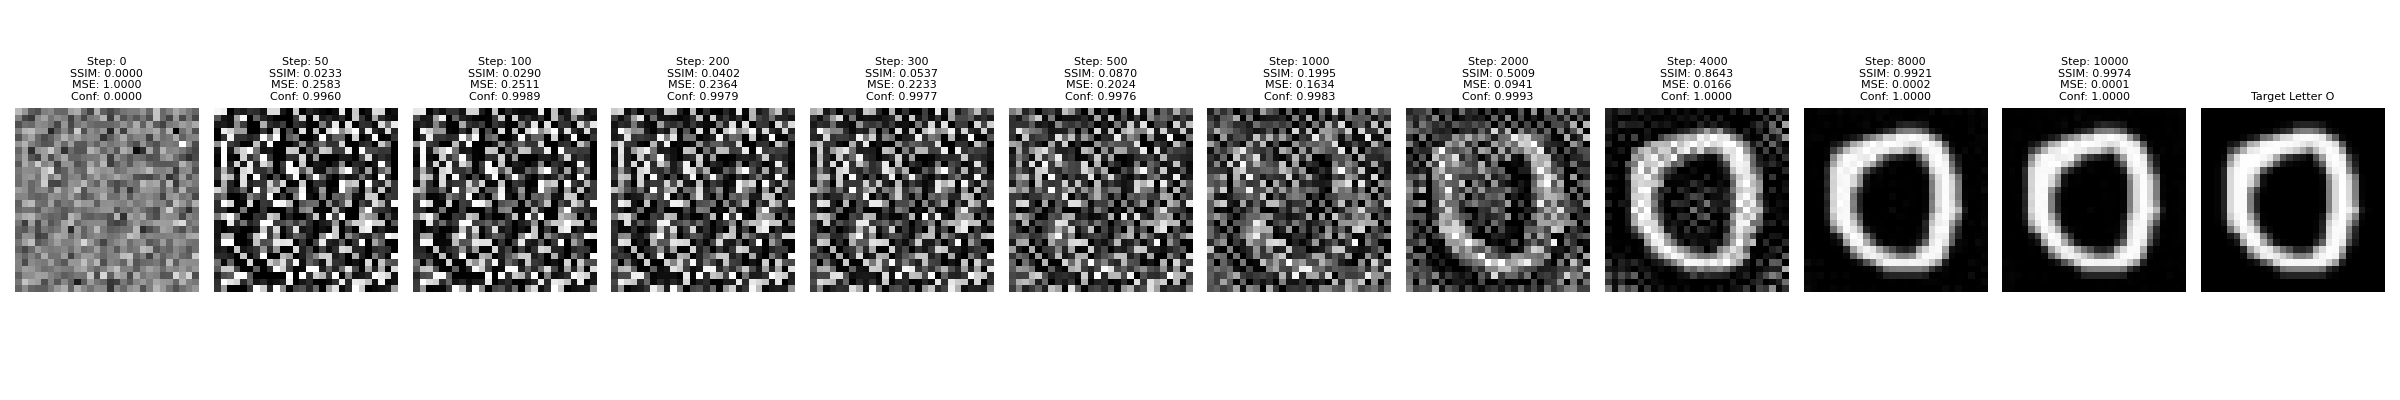

Evaluating for letter P
Step 50: SSIM=0.0154, MSE=0.2472, Conf=1.0000, Snapshot shape=(28, 28)
Step 100: SSIM=0.0218, MSE=0.2356, Conf=1.0000, Snapshot shape=(28, 28)
Step 200: SSIM=0.0415, MSE=0.2137, Conf=0.9995, Snapshot shape=(28, 28)
Step 300: SSIM=0.0660, MSE=0.1960, Conf=0.9996, Snapshot shape=(28, 28)
Step 500: SSIM=0.1268, MSE=0.1694, Conf=0.9995, Snapshot shape=(28, 28)
Step 1000: SSIM=0.2815, MSE=0.1207, Conf=0.9997, Snapshot shape=(28, 28)
Step 2000: SSIM=0.5320, MSE=0.0626, Conf=0.9999, Snapshot shape=(28, 28)
Step 4000: SSIM=0.6062, MSE=0.0382, Conf=0.9999, Snapshot shape=(28, 28)
Step 8000: SSIM=0.6451, MSE=0.0228, Conf=0.9999, Snapshot shape=(28, 28)
Step 10000: SSIM=0.6612, MSE=0.0207, Conf=0.9999, Snapshot shape=(28, 28)


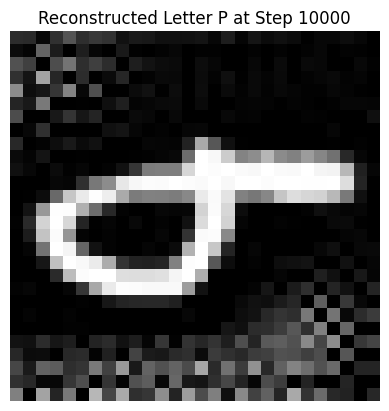

Stored 11 snapshots for letter P

Results Table for Letter P:
Step | SSIM   | MSE    | Confidence
-----|--------|--------|-----------
0    | 0.0000 | 1.0000 | 0.0000
50   | 0.0154 | 0.2472 | 1.0000
100  | 0.0218 | 0.2356 | 1.0000
200  | 0.0415 | 0.2137 | 0.9995
300  | 0.0660 | 0.1960 | 0.9996
500  | 0.1268 | 0.1694 | 0.9995
1000 | 0.2815 | 0.1207 | 0.9997
2000 | 0.5320 | 0.0626 | 0.9999
4000 | 0.6062 | 0.0382 | 0.9999
8000 | 0.6451 | 0.0228 | 0.9999
10000 | 0.6612 | 0.0207 | 0.9999
Plotting progression for letter P, 11 snapshots
Saved progression plot: /content/reconstructed_letter_P.png


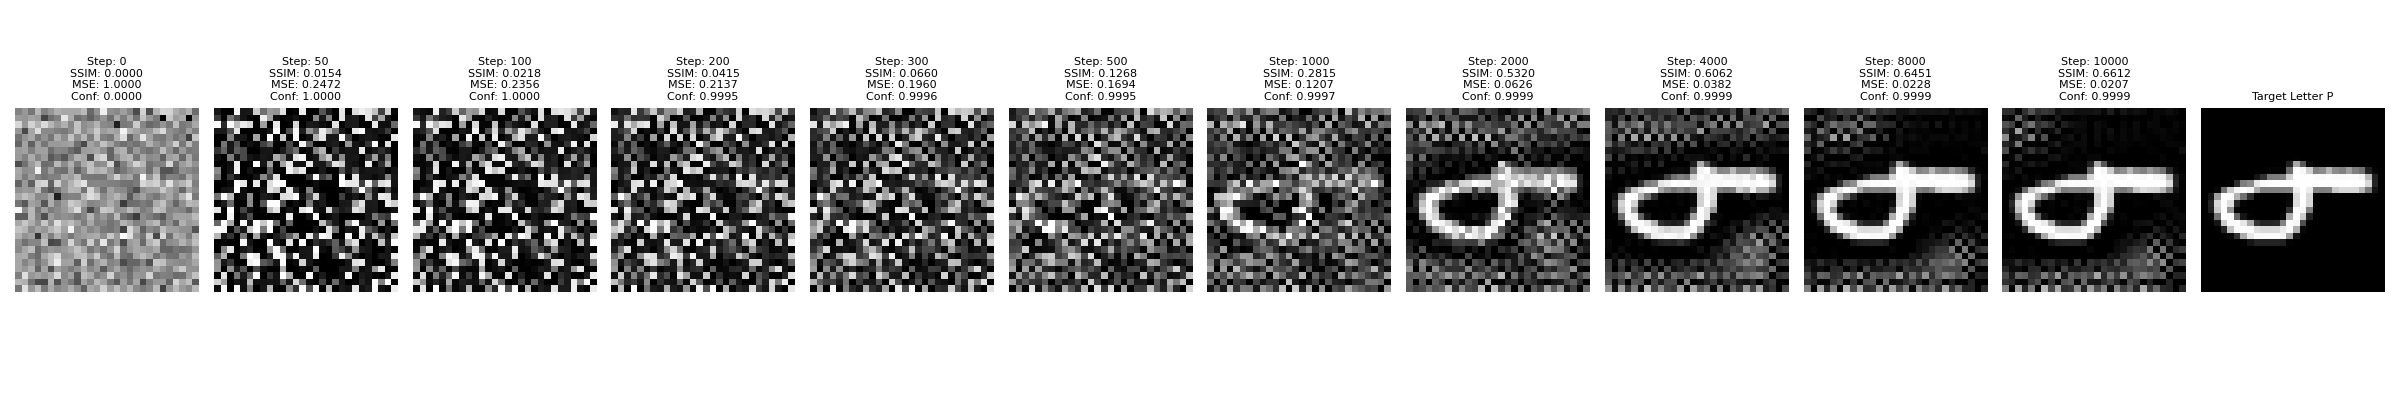

Evaluating for letter Q
Step 50: SSIM=0.0007, MSE=0.2631, Conf=1.0000, Snapshot shape=(28, 28)
Step 100: SSIM=0.0083, MSE=0.2453, Conf=1.0000, Snapshot shape=(28, 28)
Step 200: SSIM=0.0334, MSE=0.2197, Conf=0.9999, Snapshot shape=(28, 28)
Step 300: SSIM=0.0664, MSE=0.2026, Conf=0.9996, Snapshot shape=(28, 28)
Step 500: SSIM=0.1376, MSE=0.1771, Conf=0.9995, Snapshot shape=(28, 28)
Step 1000: SSIM=0.3208, MSE=0.1241, Conf=0.9998, Snapshot shape=(28, 28)
Step 2000: SSIM=0.5499, MSE=0.0627, Conf=0.9998, Snapshot shape=(28, 28)
Step 4000: SSIM=0.6354, MSE=0.0364, Conf=0.9998, Snapshot shape=(28, 28)
Step 8000: SSIM=0.6634, MSE=0.0295, Conf=0.9997, Snapshot shape=(28, 28)
Step 10000: SSIM=0.6641, MSE=0.0296, Conf=0.9997, Snapshot shape=(28, 28)


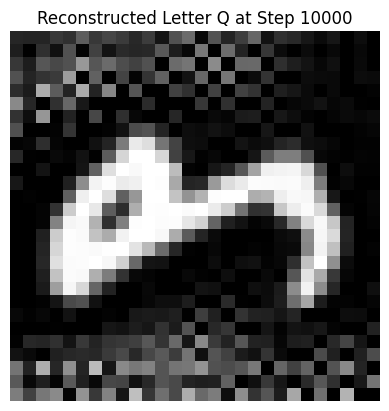

Stored 11 snapshots for letter Q

Results Table for Letter Q:
Step | SSIM   | MSE    | Confidence
-----|--------|--------|-----------
0    | 0.0000 | 1.0000 | 0.0000
50   | 0.0007 | 0.2631 | 1.0000
100  | 0.0083 | 0.2453 | 1.0000
200  | 0.0334 | 0.2197 | 0.9999
300  | 0.0664 | 0.2026 | 0.9996
500  | 0.1376 | 0.1771 | 0.9995
1000 | 0.3208 | 0.1241 | 0.9998
2000 | 0.5499 | 0.0627 | 0.9998
4000 | 0.6354 | 0.0364 | 0.9998
8000 | 0.6634 | 0.0295 | 0.9997
10000 | 0.6641 | 0.0296 | 0.9997
Plotting progression for letter Q, 11 snapshots
Saved progression plot: /content/reconstructed_letter_Q.png


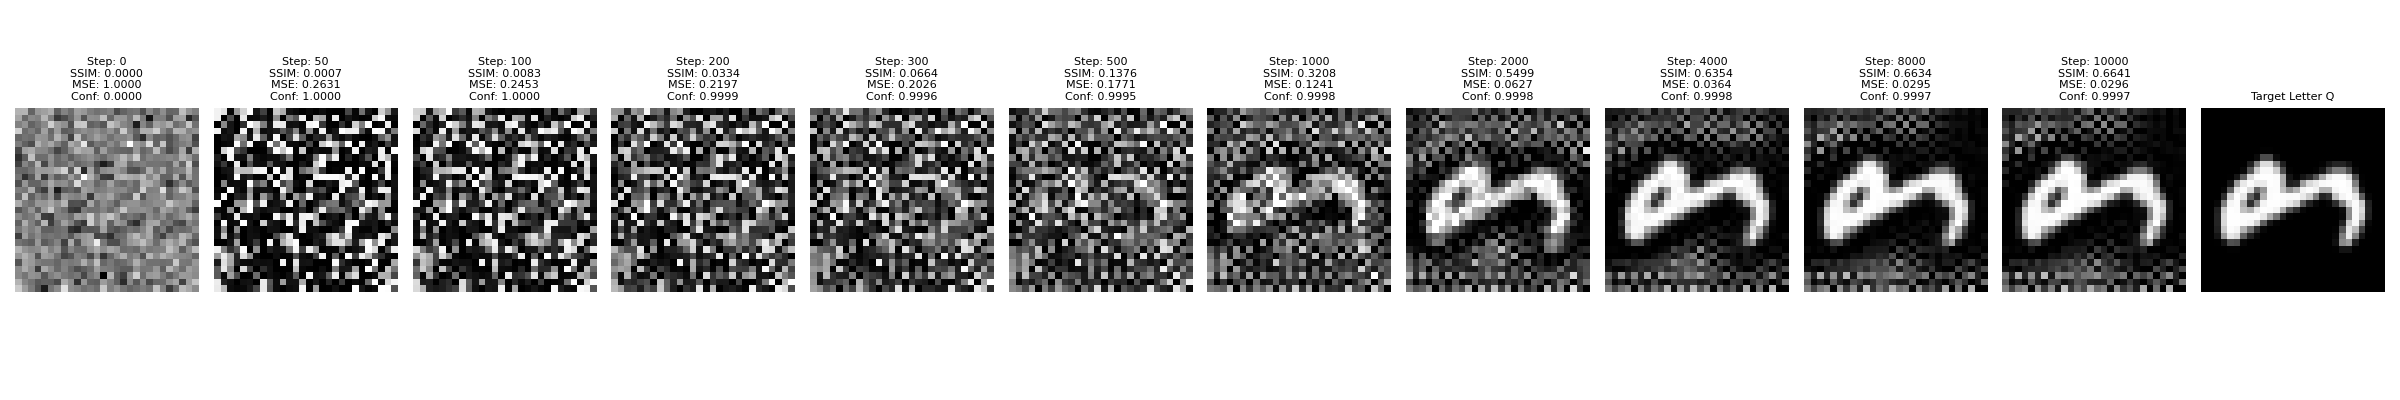

Evaluating for letter R
Step 50: SSIM=-0.0227, MSE=0.2765, Conf=1.0000, Snapshot shape=(28, 28)
Step 100: SSIM=-0.0220, MSE=0.2693, Conf=0.9999, Snapshot shape=(28, 28)
Step 200: SSIM=-0.0212, MSE=0.2546, Conf=0.9994, Snapshot shape=(28, 28)
Step 300: SSIM=-0.0187, MSE=0.2420, Conf=0.9992, Snapshot shape=(28, 28)
Step 500: SSIM=-0.0078, MSE=0.2226, Conf=0.9991, Snapshot shape=(28, 28)
Step 1000: SSIM=0.0303, MSE=0.1907, Conf=0.9988, Snapshot shape=(28, 28)
Step 2000: SSIM=0.1964, MSE=0.1363, Conf=0.9992, Snapshot shape=(28, 28)
Step 4000: SSIM=0.5954, MSE=0.0512, Conf=0.9997, Snapshot shape=(28, 28)
Step 8000: SSIM=0.7031, MSE=0.0275, Conf=0.9997, Snapshot shape=(28, 28)
Step 10000: SSIM=0.7076, MSE=0.0259, Conf=0.9997, Snapshot shape=(28, 28)


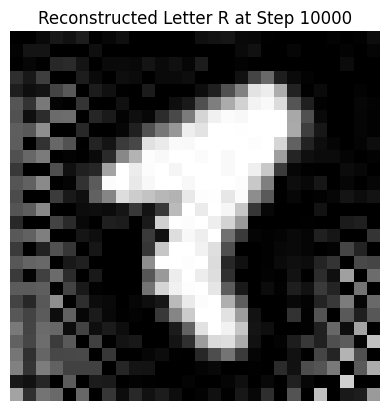

Stored 11 snapshots for letter R

Results Table for Letter R:
Step | SSIM   | MSE    | Confidence
-----|--------|--------|-----------
0    | 0.0000 | 1.0000 | 0.0000
50   | -0.0227 | 0.2765 | 1.0000
100  | -0.0220 | 0.2693 | 0.9999
200  | -0.0212 | 0.2546 | 0.9994
300  | -0.0187 | 0.2420 | 0.9992
500  | -0.0078 | 0.2226 | 0.9991
1000 | 0.0303 | 0.1907 | 0.9988
2000 | 0.1964 | 0.1363 | 0.9992
4000 | 0.5954 | 0.0512 | 0.9997
8000 | 0.7031 | 0.0275 | 0.9997
10000 | 0.7076 | 0.0259 | 0.9997
Plotting progression for letter R, 11 snapshots
Saved progression plot: /content/reconstructed_letter_R.png


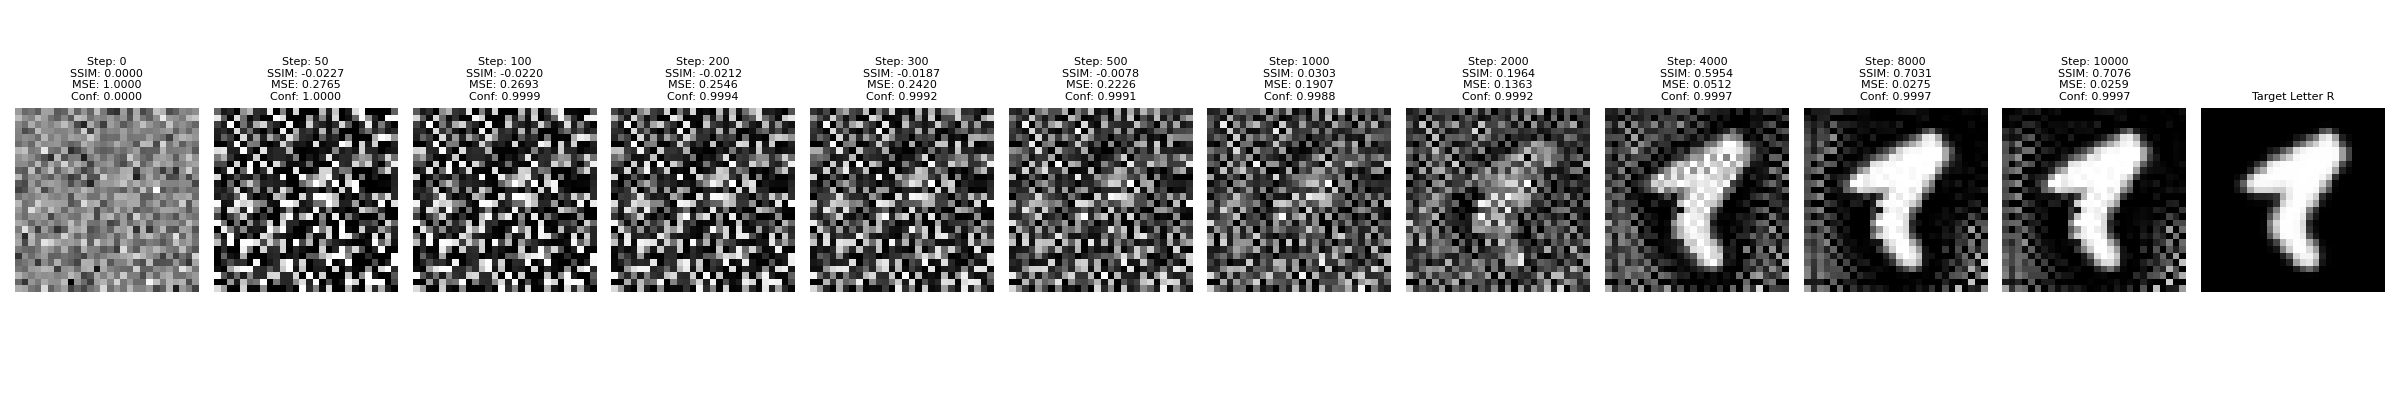

Evaluating for letter S
Step 50: SSIM=-0.0518, MSE=0.2837, Conf=0.9996, Snapshot shape=(28, 28)
Step 100: SSIM=-0.0492, MSE=0.2743, Conf=0.9995, Snapshot shape=(28, 28)
Step 200: SSIM=-0.0404, MSE=0.2552, Conf=0.9983, Snapshot shape=(28, 28)
Step 300: SSIM=-0.0297, MSE=0.2401, Conf=0.9982, Snapshot shape=(28, 28)
Step 500: SSIM=-0.0082, MSE=0.2193, Conf=0.9982, Snapshot shape=(28, 28)
Step 1000: SSIM=0.0481, MSE=0.1854, Conf=0.9987, Snapshot shape=(28, 28)
Step 2000: SSIM=0.3018, MSE=0.1216, Conf=0.9996, Snapshot shape=(28, 28)
Step 4000: SSIM=0.6855, MSE=0.0411, Conf=0.9999, Snapshot shape=(28, 28)
Step 8000: SSIM=0.8399, MSE=0.0102, Conf=0.9999, Snapshot shape=(28, 28)
Step 10000: SSIM=0.8667, MSE=0.0069, Conf=0.9999, Snapshot shape=(28, 28)


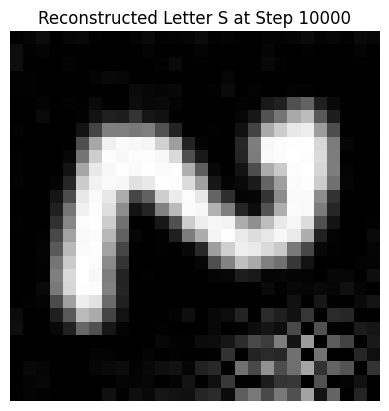

Stored 11 snapshots for letter S

Results Table for Letter S:
Step | SSIM   | MSE    | Confidence
-----|--------|--------|-----------
0    | 0.0000 | 1.0000 | 0.0000
50   | -0.0518 | 0.2837 | 0.9996
100  | -0.0492 | 0.2743 | 0.9995
200  | -0.0404 | 0.2552 | 0.9983
300  | -0.0297 | 0.2401 | 0.9982
500  | -0.0082 | 0.2193 | 0.9982
1000 | 0.0481 | 0.1854 | 0.9987
2000 | 0.3018 | 0.1216 | 0.9996
4000 | 0.6855 | 0.0411 | 0.9999
8000 | 0.8399 | 0.0102 | 0.9999
10000 | 0.8667 | 0.0069 | 0.9999
Plotting progression for letter S, 11 snapshots
Saved progression plot: /content/reconstructed_letter_S.png


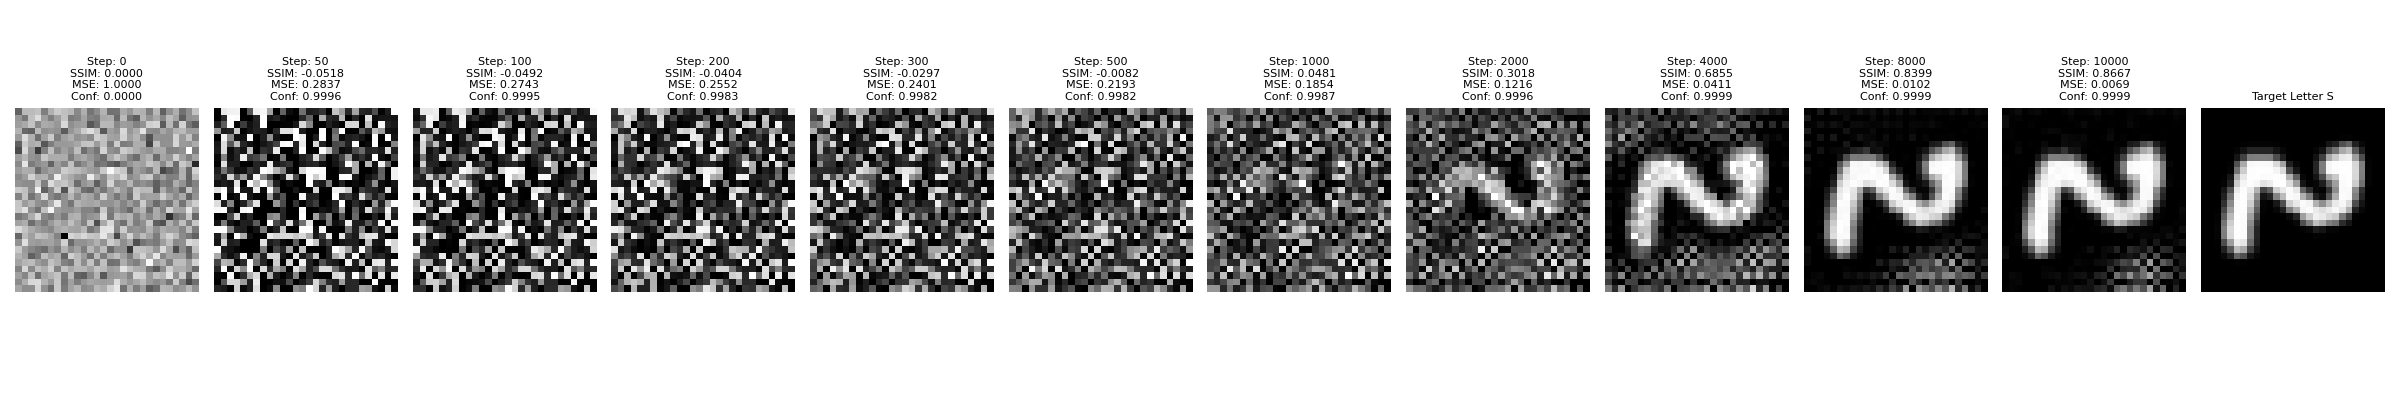

Evaluating for letter T
Step 50: SSIM=-0.0152, MSE=0.2593, Conf=0.9993, Snapshot shape=(28, 28)
Step 100: SSIM=-0.0128, MSE=0.2526, Conf=0.9996, Snapshot shape=(28, 28)
Step 200: SSIM=-0.0049, MSE=0.2381, Conf=0.9976, Snapshot shape=(28, 28)
Step 300: SSIM=0.0065, MSE=0.2246, Conf=0.9970, Snapshot shape=(28, 28)
Step 500: SSIM=0.0384, MSE=0.2009, Conf=0.9985, Snapshot shape=(28, 28)
Step 1000: SSIM=0.1528, MSE=0.1563, Conf=0.9992, Snapshot shape=(28, 28)
Step 2000: SSIM=0.3622, MSE=0.1027, Conf=0.9995, Snapshot shape=(28, 28)
Step 4000: SSIM=0.4825, MSE=0.0643, Conf=0.9997, Snapshot shape=(28, 28)
Step 8000: SSIM=0.5587, MSE=0.0347, Conf=0.9998, Snapshot shape=(28, 28)
Step 10000: SSIM=0.5636, MSE=0.0321, Conf=0.9998, Snapshot shape=(28, 28)


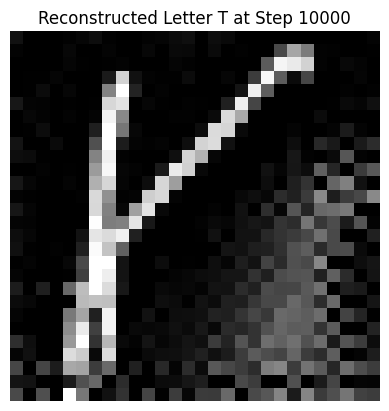

Stored 11 snapshots for letter T

Results Table for Letter T:
Step | SSIM   | MSE    | Confidence
-----|--------|--------|-----------
0    | 0.0000 | 1.0000 | 0.0000
50   | -0.0152 | 0.2593 | 0.9993
100  | -0.0128 | 0.2526 | 0.9996
200  | -0.0049 | 0.2381 | 0.9976
300  | 0.0065 | 0.2246 | 0.9970
500  | 0.0384 | 0.2009 | 0.9985
1000 | 0.1528 | 0.1563 | 0.9992
2000 | 0.3622 | 0.1027 | 0.9995
4000 | 0.4825 | 0.0643 | 0.9997
8000 | 0.5587 | 0.0347 | 0.9998
10000 | 0.5636 | 0.0321 | 0.9998
Plotting progression for letter T, 11 snapshots
Saved progression plot: /content/reconstructed_letter_T.png


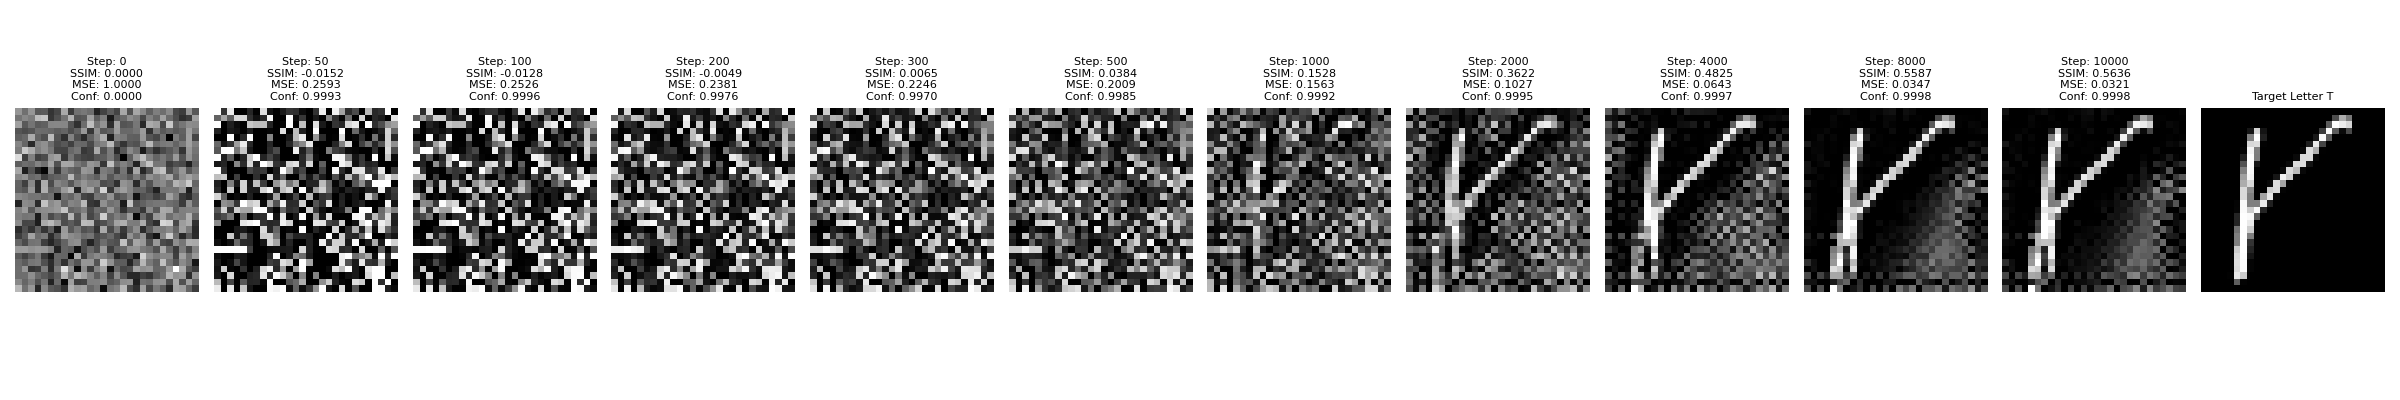

Evaluating for letter U
Step 50: SSIM=-0.0139, MSE=0.2547, Conf=1.0000, Snapshot shape=(28, 28)
Step 100: SSIM=-0.0133, MSE=0.2476, Conf=0.9999, Snapshot shape=(28, 28)
Step 200: SSIM=-0.0097, MSE=0.2332, Conf=0.9989, Snapshot shape=(28, 28)
Step 300: SSIM=-0.0042, MSE=0.2216, Conf=0.9983, Snapshot shape=(28, 28)
Step 500: SSIM=0.0098, MSE=0.2046, Conf=0.9977, Snapshot shape=(28, 28)
Step 1000: SSIM=0.0618, MSE=0.1730, Conf=0.9973, Snapshot shape=(28, 28)
Step 2000: SSIM=0.2308, MSE=0.1237, Conf=0.9983, Snapshot shape=(28, 28)
Step 4000: SSIM=0.6720, MSE=0.0418, Conf=0.9996, Snapshot shape=(28, 28)
Step 8000: SSIM=0.7777, MSE=0.0172, Conf=0.9997, Snapshot shape=(28, 28)
Step 10000: SSIM=0.8058, MSE=0.0120, Conf=0.9997, Snapshot shape=(28, 28)


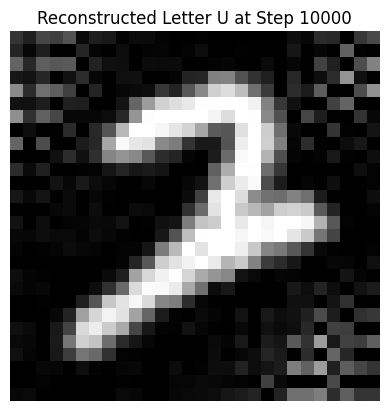

Stored 11 snapshots for letter U

Results Table for Letter U:
Step | SSIM   | MSE    | Confidence
-----|--------|--------|-----------
0    | 0.0000 | 1.0000 | 0.0000
50   | -0.0139 | 0.2547 | 1.0000
100  | -0.0133 | 0.2476 | 0.9999
200  | -0.0097 | 0.2332 | 0.9989
300  | -0.0042 | 0.2216 | 0.9983
500  | 0.0098 | 0.2046 | 0.9977
1000 | 0.0618 | 0.1730 | 0.9973
2000 | 0.2308 | 0.1237 | 0.9983
4000 | 0.6720 | 0.0418 | 0.9996
8000 | 0.7777 | 0.0172 | 0.9997
10000 | 0.8058 | 0.0120 | 0.9997
Plotting progression for letter U, 11 snapshots
Saved progression plot: /content/reconstructed_letter_U.png


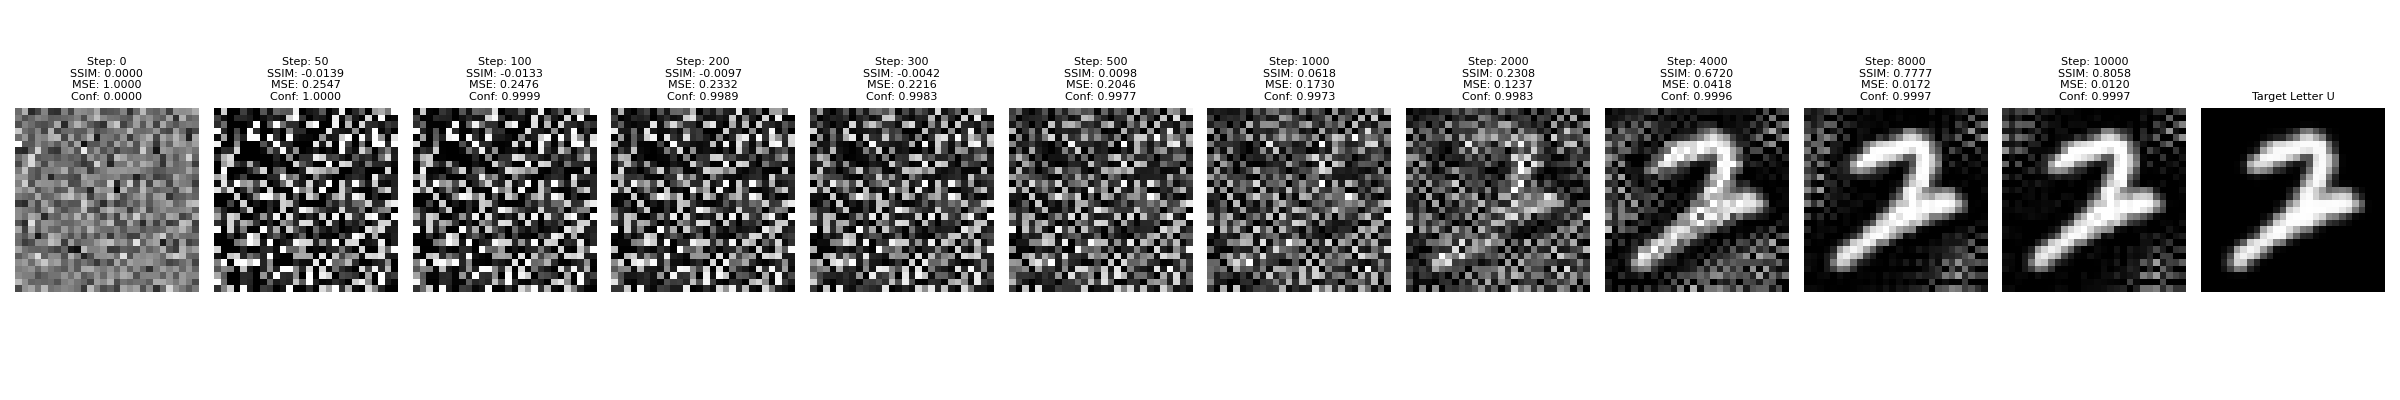

Evaluating for letter V
Step 50: SSIM=0.0083, MSE=0.2445, Conf=0.9995, Snapshot shape=(28, 28)
Step 100: SSIM=0.0103, MSE=0.2382, Conf=0.9994, Snapshot shape=(28, 28)
Step 200: SSIM=0.0172, MSE=0.2254, Conf=0.9986, Snapshot shape=(28, 28)
Step 300: SSIM=0.0254, MSE=0.2134, Conf=0.9984, Snapshot shape=(28, 28)
Step 500: SSIM=0.0425, MSE=0.1948, Conf=0.9977, Snapshot shape=(28, 28)
Step 1000: SSIM=0.1053, MSE=0.1614, Conf=0.9984, Snapshot shape=(28, 28)
Step 2000: SSIM=0.3622, MSE=0.0962, Conf=0.9995, Snapshot shape=(28, 28)
Step 4000: SSIM=0.6253, MSE=0.0402, Conf=0.9999, Snapshot shape=(28, 28)
Step 8000: SSIM=0.7178, MSE=0.0166, Conf=1.0000, Snapshot shape=(28, 28)
Step 10000: SSIM=0.7647, MSE=0.0082, Conf=1.0000, Snapshot shape=(28, 28)


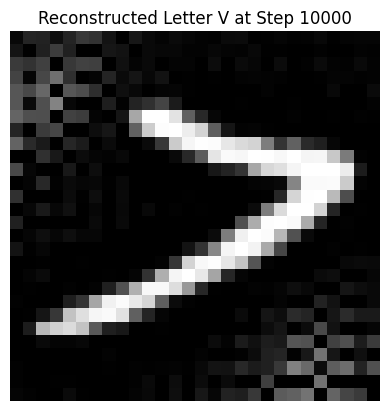

Stored 11 snapshots for letter V

Results Table for Letter V:
Step | SSIM   | MSE    | Confidence
-----|--------|--------|-----------
0    | 0.0000 | 1.0000 | 0.0000
50   | 0.0083 | 0.2445 | 0.9995
100  | 0.0103 | 0.2382 | 0.9994
200  | 0.0172 | 0.2254 | 0.9986
300  | 0.0254 | 0.2134 | 0.9984
500  | 0.0425 | 0.1948 | 0.9977
1000 | 0.1053 | 0.1614 | 0.9984
2000 | 0.3622 | 0.0962 | 0.9995
4000 | 0.6253 | 0.0402 | 0.9999
8000 | 0.7178 | 0.0166 | 1.0000
10000 | 0.7647 | 0.0082 | 1.0000
Plotting progression for letter V, 11 snapshots
Saved progression plot: /content/reconstructed_letter_V.png


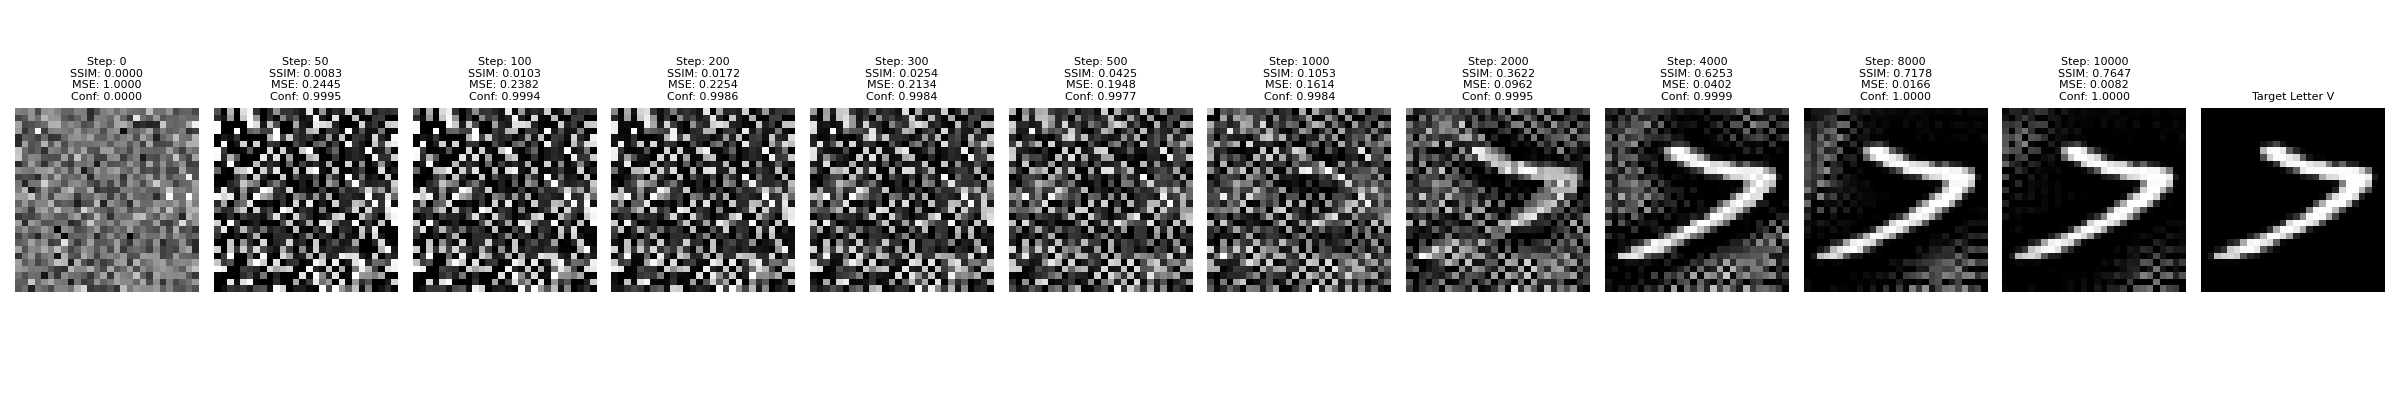

Evaluating for letter W
Step 50: SSIM=0.0467, MSE=0.3036, Conf=1.0000, Snapshot shape=(28, 28)
Step 100: SSIM=0.0525, MSE=0.2901, Conf=1.0000, Snapshot shape=(28, 28)
Step 200: SSIM=0.0686, MSE=0.2647, Conf=0.9994, Snapshot shape=(28, 28)
Step 300: SSIM=0.0869, MSE=0.2455, Conf=0.9995, Snapshot shape=(28, 28)
Step 500: SSIM=0.1322, MSE=0.2154, Conf=0.9996, Snapshot shape=(28, 28)
Step 1000: SSIM=0.3216, MSE=0.1512, Conf=0.9998, Snapshot shape=(28, 28)
Step 2000: SSIM=0.7256, MSE=0.0551, Conf=0.9999, Snapshot shape=(28, 28)
Step 4000: SSIM=0.9075, MSE=0.0131, Conf=1.0000, Snapshot shape=(28, 28)
Step 8000: SSIM=0.9397, MSE=0.0029, Conf=1.0000, Snapshot shape=(28, 28)
Step 10000: SSIM=0.9405, MSE=0.0027, Conf=1.0000, Snapshot shape=(28, 28)


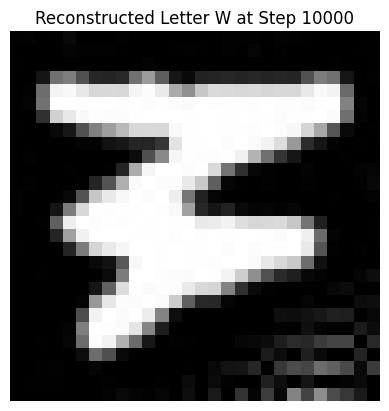

Stored 11 snapshots for letter W

Results Table for Letter W:
Step | SSIM   | MSE    | Confidence
-----|--------|--------|-----------
0    | 0.0000 | 1.0000 | 0.0000
50   | 0.0467 | 0.3036 | 1.0000
100  | 0.0525 | 0.2901 | 1.0000
200  | 0.0686 | 0.2647 | 0.9994
300  | 0.0869 | 0.2455 | 0.9995
500  | 0.1322 | 0.2154 | 0.9996
1000 | 0.3216 | 0.1512 | 0.9998
2000 | 0.7256 | 0.0551 | 0.9999
4000 | 0.9075 | 0.0131 | 1.0000
8000 | 0.9397 | 0.0029 | 1.0000
10000 | 0.9405 | 0.0027 | 1.0000
Plotting progression for letter W, 11 snapshots
Saved progression plot: /content/reconstructed_letter_W.png


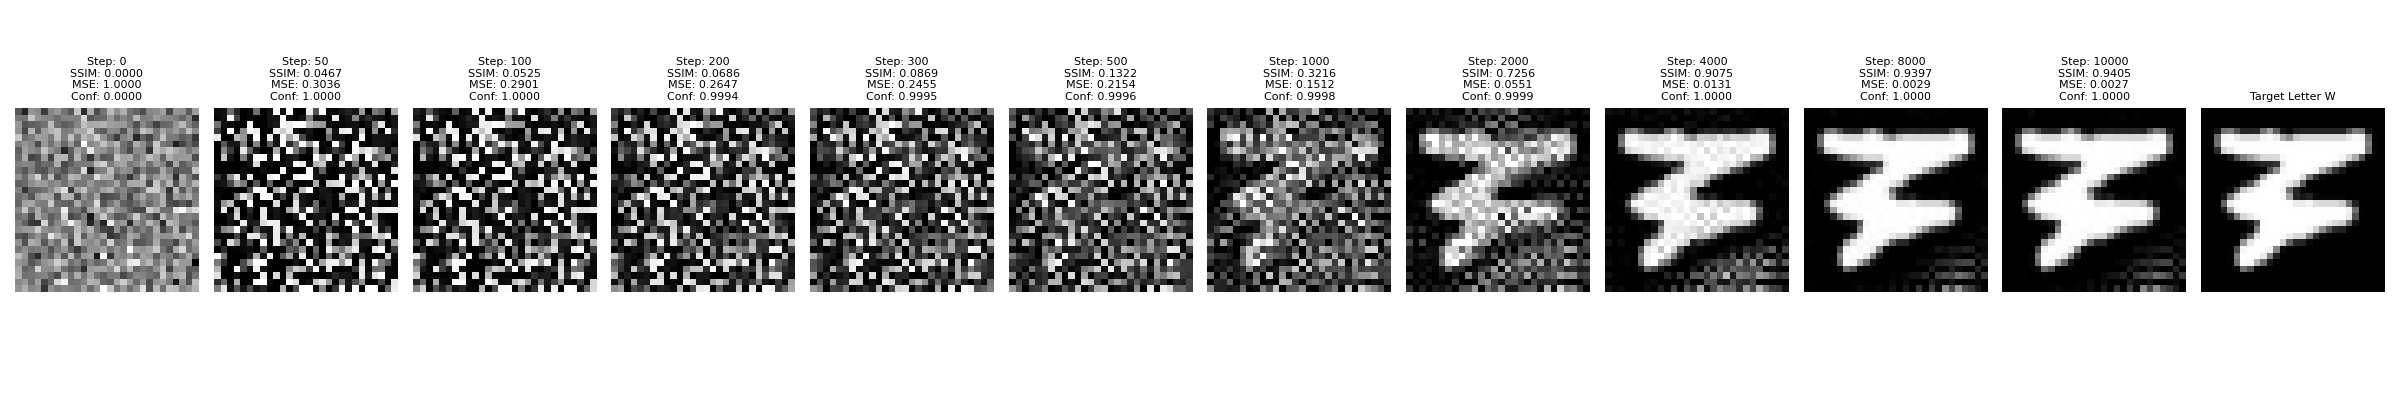

Evaluating for letter X
Step 50: SSIM=-0.0037, MSE=0.2647, Conf=0.9997, Snapshot shape=(28, 28)
Step 100: SSIM=-0.0009, MSE=0.2563, Conf=0.9996, Snapshot shape=(28, 28)
Step 200: SSIM=0.0068, MSE=0.2389, Conf=0.9984, Snapshot shape=(28, 28)
Step 300: SSIM=0.0153, MSE=0.2238, Conf=0.9980, Snapshot shape=(28, 28)
Step 500: SSIM=0.0358, MSE=0.1998, Conf=0.9981, Snapshot shape=(28, 28)
Step 1000: SSIM=0.1098, MSE=0.1595, Conf=0.9978, Snapshot shape=(28, 28)
Step 2000: SSIM=0.3043, MSE=0.1052, Conf=0.9994, Snapshot shape=(28, 28)
Step 4000: SSIM=0.7114, MSE=0.0315, Conf=1.0000, Snapshot shape=(28, 28)
Step 8000: SSIM=0.8227, MSE=0.0112, Conf=1.0000, Snapshot shape=(28, 28)
Step 10000: SSIM=0.8690, MSE=0.0057, Conf=0.9999, Snapshot shape=(28, 28)


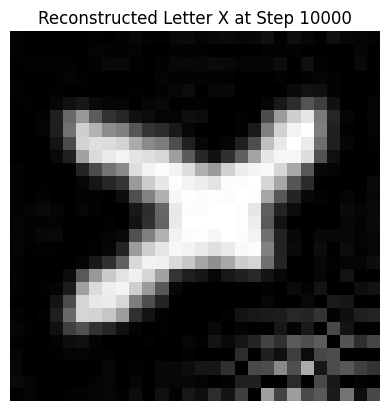

Stored 11 snapshots for letter X

Results Table for Letter X:
Step | SSIM   | MSE    | Confidence
-----|--------|--------|-----------
0    | 0.0000 | 1.0000 | 0.0000
50   | -0.0037 | 0.2647 | 0.9997
100  | -0.0009 | 0.2563 | 0.9996
200  | 0.0068 | 0.2389 | 0.9984
300  | 0.0153 | 0.2238 | 0.9980
500  | 0.0358 | 0.1998 | 0.9981
1000 | 0.1098 | 0.1595 | 0.9978
2000 | 0.3043 | 0.1052 | 0.9994
4000 | 0.7114 | 0.0315 | 1.0000
8000 | 0.8227 | 0.0112 | 1.0000
10000 | 0.8690 | 0.0057 | 0.9999
Plotting progression for letter X, 11 snapshots
Saved progression plot: /content/reconstructed_letter_X.png


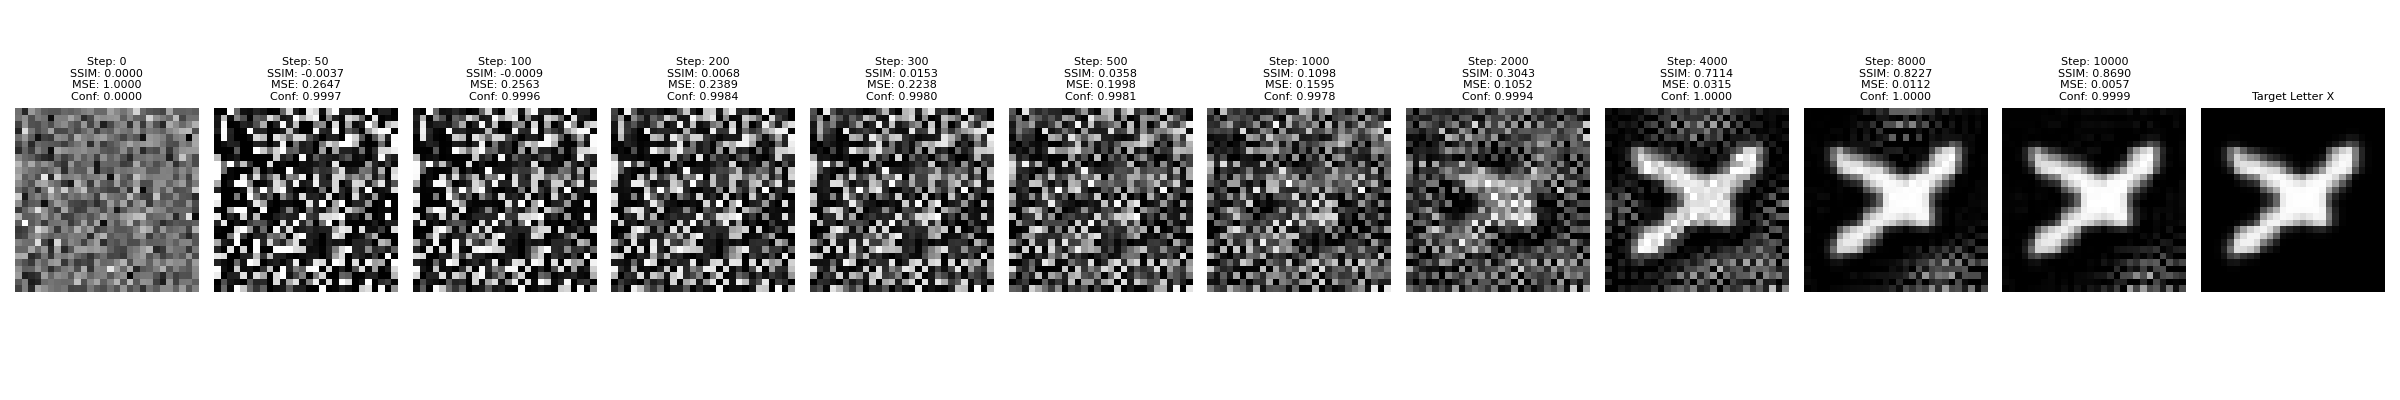

Evaluating for letter Y
Step 50: SSIM=-0.0037, MSE=0.2614, Conf=1.0000, Snapshot shape=(28, 28)
Step 100: SSIM=0.0036, MSE=0.2493, Conf=1.0000, Snapshot shape=(28, 28)
Step 200: SSIM=0.0241, MSE=0.2271, Conf=0.9999, Snapshot shape=(28, 28)
Step 300: SSIM=0.0491, MSE=0.2097, Conf=0.9996, Snapshot shape=(28, 28)
Step 500: SSIM=0.1064, MSE=0.1833, Conf=0.9996, Snapshot shape=(28, 28)
Step 1000: SSIM=0.3265, MSE=0.1251, Conf=0.9996, Snapshot shape=(28, 28)
Step 2000: SSIM=0.6945, MSE=0.0486, Conf=0.9998, Snapshot shape=(28, 28)
Step 4000: SSIM=0.8724, MSE=0.0154, Conf=0.9999, Snapshot shape=(28, 28)
Step 8000: SSIM=0.9010, MSE=0.0089, Conf=0.9999, Snapshot shape=(28, 28)
Step 10000: SSIM=0.9041, MSE=0.0072, Conf=0.9999, Snapshot shape=(28, 28)


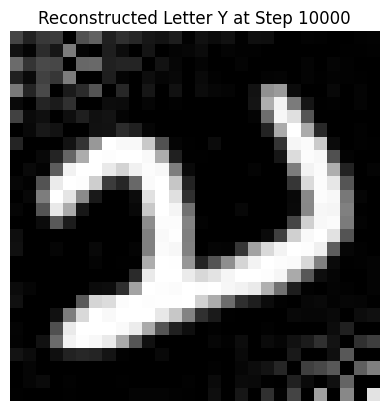

Stored 11 snapshots for letter Y

Results Table for Letter Y:
Step | SSIM   | MSE    | Confidence
-----|--------|--------|-----------
0    | 0.0000 | 1.0000 | 0.0000
50   | -0.0037 | 0.2614 | 1.0000
100  | 0.0036 | 0.2493 | 1.0000
200  | 0.0241 | 0.2271 | 0.9999
300  | 0.0491 | 0.2097 | 0.9996
500  | 0.1064 | 0.1833 | 0.9996
1000 | 0.3265 | 0.1251 | 0.9996
2000 | 0.6945 | 0.0486 | 0.9998
4000 | 0.8724 | 0.0154 | 0.9999
8000 | 0.9010 | 0.0089 | 0.9999
10000 | 0.9041 | 0.0072 | 0.9999
Plotting progression for letter Y, 11 snapshots
Saved progression plot: /content/reconstructed_letter_Y.png


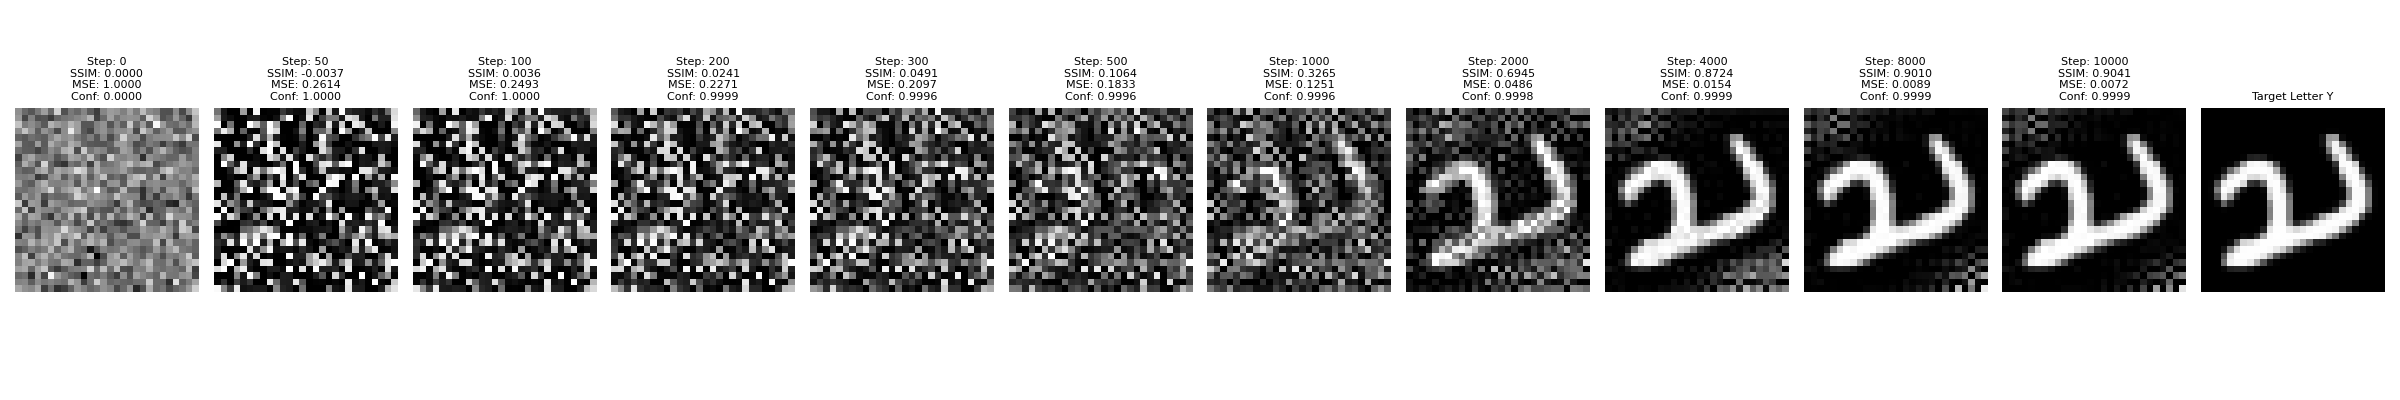

Evaluating for letter Z
Step 50: SSIM=0.0159, MSE=0.2494, Conf=1.0000, Snapshot shape=(28, 28)
Step 100: SSIM=0.0228, MSE=0.2363, Conf=1.0000, Snapshot shape=(28, 28)
Step 200: SSIM=0.0414, MSE=0.2131, Conf=0.9993, Snapshot shape=(28, 28)
Step 300: SSIM=0.0673, MSE=0.1940, Conf=0.9990, Snapshot shape=(28, 28)
Step 500: SSIM=0.1494, MSE=0.1614, Conf=0.9995, Snapshot shape=(28, 28)
Step 1000: SSIM=0.3766, MSE=0.1041, Conf=0.9997, Snapshot shape=(28, 28)
Step 2000: SSIM=0.5424, MSE=0.0613, Conf=0.9998, Snapshot shape=(28, 28)
Step 4000: SSIM=0.6144, MSE=0.0376, Conf=0.9999, Snapshot shape=(28, 28)
Step 8000: SSIM=0.7030, MSE=0.0106, Conf=0.9999, Snapshot shape=(28, 28)
Step 10000: SSIM=0.7952, MSE=0.0040, Conf=0.9999, Snapshot shape=(28, 28)


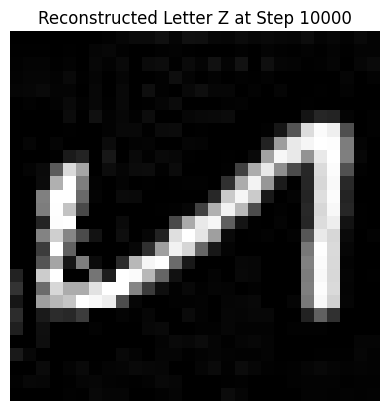

Stored 11 snapshots for letter Z

Results Table for Letter Z:
Step | SSIM   | MSE    | Confidence
-----|--------|--------|-----------
0    | 0.0000 | 1.0000 | 0.0000
50   | 0.0159 | 0.2494 | 1.0000
100  | 0.0228 | 0.2363 | 1.0000
200  | 0.0414 | 0.2131 | 0.9993
300  | 0.0673 | 0.1940 | 0.9990
500  | 0.1494 | 0.1614 | 0.9995
1000 | 0.3766 | 0.1041 | 0.9997
2000 | 0.5424 | 0.0613 | 0.9998
4000 | 0.6144 | 0.0376 | 0.9999
8000 | 0.7030 | 0.0106 | 0.9999
10000 | 0.7952 | 0.0040 | 0.9999
Plotting progression for letter Z, 11 snapshots
Saved progression plot: /content/reconstructed_letter_Z.png


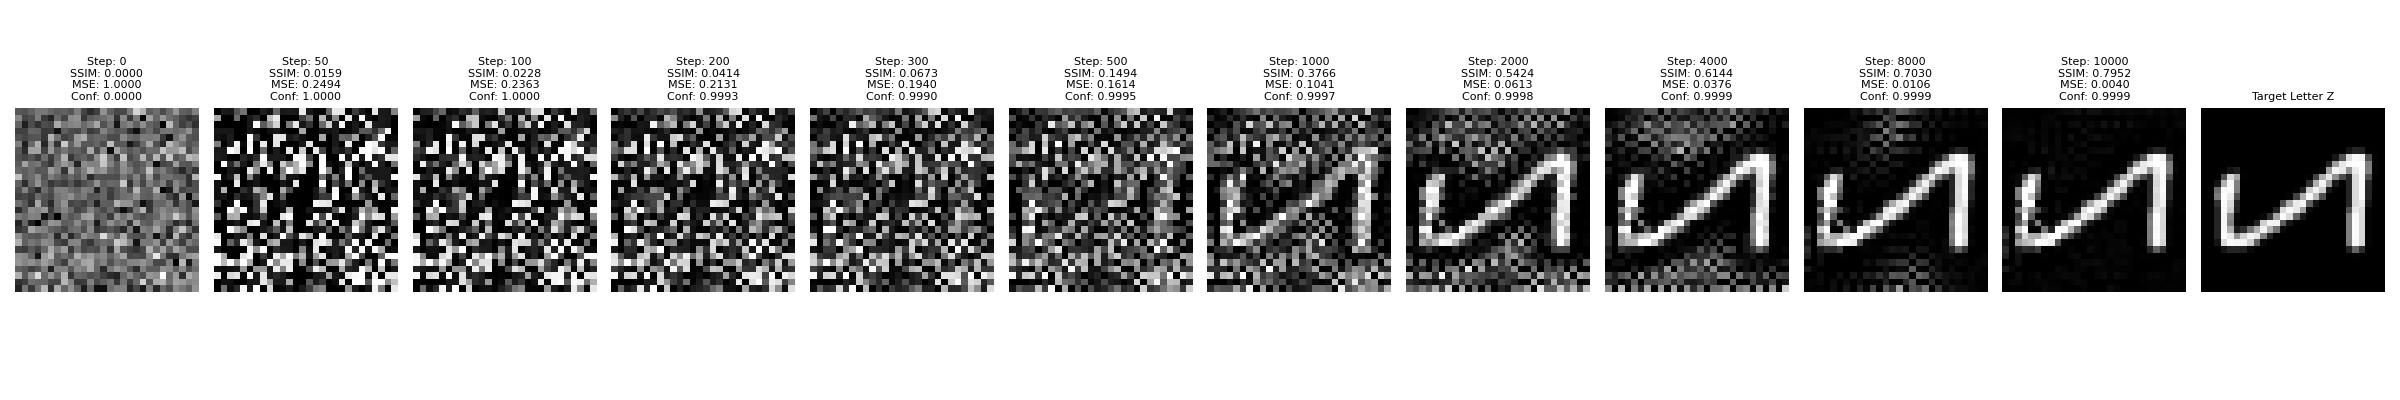

In [20]:
# Initialize dictionaries for results
all_results = {
    'Letter': [],
    'SSIM': [],
    'MSE': [],
    'Confidence': [],
    'CE Loss': [],
    'Perceptual Loss': [],
    'TV Loss': [],
    'Total Loss': [],
}

# Store data per letter
letter_data = {}

# Determine which letters to process
if isinstance(letters, str):
    letter = letters.upper()
    if letter not in [chr(i) for i in range(65, 91)]:
        raise ValueError(f'Invalid letter: {letter}. Must be A-Z.')
    target_labels = [ord(letter) - 64]
elif isinstance(letters, list):
    target_labels = [ord(letter.upper()) - 64 for letter in letters]
else:
    target_labels = range(1, 27)

# Loop through selected letter(s)
for target_label in target_labels:
    letter = chr(target_label + 64)
    print(f'Evaluating for letter {letter}')

    # Get a single target image
    for img, label in train_dataset:
        if label == target_label:
            target_image = img.unsqueeze(0).to(device)
            break
    original_np = target_image.squeeze().cpu().numpy()

    # Initialize noise
    initial_img = torch.randn((1, 1, 28, 28), device=device)
    reconstructed_img = initial_img.clone().requires_grad_(True)
    optimizer = optim.AdamW([reconstructed_img], lr=0.005)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.9)
    loss_fn_ce = nn.CrossEntropyLoss()
    lambda_perceptual = 1.5
    lambda_tv = 0.01

    # Log metrics and snapshots
    steps = [0]
    ssim_values = [0.0000]
    mse_values = [1.0000]
    conf_values = [0.0000]
    pred_values = [0]
    ce_losses = [float('nan')]
    perceptual_losses = [float('nan')]
    tv_losses = [float('nan')]
    total_losses = [float('nan')]
    snapshots = [initial_img.squeeze().detach().cpu().numpy()]
    key_steps = [50, 100, 200, 300, 500, 1000, 2000, 4000, 8000, 10000]

    # Inversion loop
    for step in range(1, 10001):
        optimizer.zero_grad()
        output = model(reconstructed_img)
        ce_loss = loss_fn_ce(output, torch.tensor([target_label - 1], dtype=torch.long).to(device))
        features_target = model.get_features(target_image)
        features_recon = model.get_features(reconstructed_img)
        perceptual_loss = F.mse_loss(features_recon, features_target)
        tv_loss = total_variation_loss(reconstructed_img)
        total_loss = ce_loss + lambda_perceptual * perceptual_loss + lambda_tv * tv_loss
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_([reconstructed_img], 5.0)
        optimizer.step()
        scheduler.step()
        with torch.no_grad():
            reconstructed_img.clamp_(0, 1)

        if step in key_steps:
            rec_np = reconstructed_img.squeeze().detach().cpu().numpy()
            ssim_val, mse_val, pred_val, conf_val = compute_metrics(original_np, rec_np, reconstructed_img, target_label)
            print(f"Step {step}: SSIM={ssim_val:.4f}, MSE={mse_val:.4f}, Conf={conf_val:.4f}, Snapshot shape={rec_np.shape}")
            steps.append(step)
            ssim_values.append(ssim_val)
            mse_values.append(mse_val)
            conf_values.append(conf_val)
            pred_values.append(pred_val)
            ce_losses.append(ce_loss.item())
            perceptual_losses.append(perceptual_loss.item())
            tv_losses.append(tv_loss.item())
            total_losses.append(total_loss.item())
            snapshots.append(rec_np)
            if step == 10000:
                plt.imshow(rec_np, cmap='gray')
                plt.title(f'Reconstructed Letter {letter} at Step {step}')
                plt.axis('off')
                plt.savefig(f'reconstructed_{letter}_step_{step}.png')
                plt.show()

    # Store results
    all_results['Letter'].append(letter)
    all_results['SSIM'].append(ssim_values[-1])
    all_results['MSE'].append(mse_values[-1])
    all_results['Confidence'].append(conf_values[-1])
    all_results['CE Loss'].append(ce_losses[-1])
    all_results['Perceptual Loss'].append(perceptual_losses[-1])
    all_results['TV Loss'].append(tv_losses[-1])
    all_results['Total Loss'].append(total_losses[-1])

    # Store letter data
    letter_data[letter] = {
        'steps': steps,
        'ssim_values': ssim_values,
        'mse_values': mse_values,
        'conf_values': conf_values,
        'snapshots': snapshots,
        'target_image': original_np
    }
    print(f"Stored {len(snapshots)} snapshots for letter {letter}")

    # Results table
    print(f'\nResults Table for Letter {letter}:')
    print('Step | SSIM   | MSE    | Confidence')
    print('-----|--------|--------|-----------')
    for step, ssim_val, mse_val, conf_val in zip(steps, ssim_values, mse_values, conf_values):
        print(f'{step:<4} | {ssim_val:.4f} | {mse_val:.4f} | {conf_val:.4f}')

    # Plot progression with all snapshots
    try:
        print(f"Plotting progression for letter {letter}, {len(snapshots)} snapshots")
        num_snapshots = len(snapshots)
        num_cols = min(num_snapshots + 1, 12)  # Include target image
        plt.figure(figsize=(num_cols * 2, 4))
        for i, step in enumerate(steps):
            if i < num_snapshots:
                plt.subplot(1, num_cols, i + 1)
                plt.imshow(snapshots[i], cmap='gray')
                plt.title(f'Step: {step}\nSSIM: {ssim_values[i]:.4f}\nMSE: {mse_values[i]:.4f}\nConf: {conf_values[i]:.4f}', fontsize=8)
                plt.axis('off')
        plt.subplot(1, num_cols, num_cols)
        plt.imshow(original_np, cmap='gray')
        plt.title(f'Target Letter {letter}', fontsize=8)
        plt.axis('off')
        plt.tight_layout()
        progression_path = f'/content/reconstructed_letter_{letter}.png'
        plt.savefig(progression_path)
        plt.close()
        print(f"Saved progression plot: {progression_path}")
        display(Image(filename=progression_path))
    except Exception as e:
        print(f"Error saving progression plot for letter {letter}: {e}")

## Plot Original vs Reconstructed (All Letters)

Generates a side-by-side comparison of original and reconstructed images for all processed letters (only if multiple letters are processed).

Plotting original vs reconstructed for 26 letters
Saved side-by-side plot: ./original_vs_reconstructed_all_letters.png


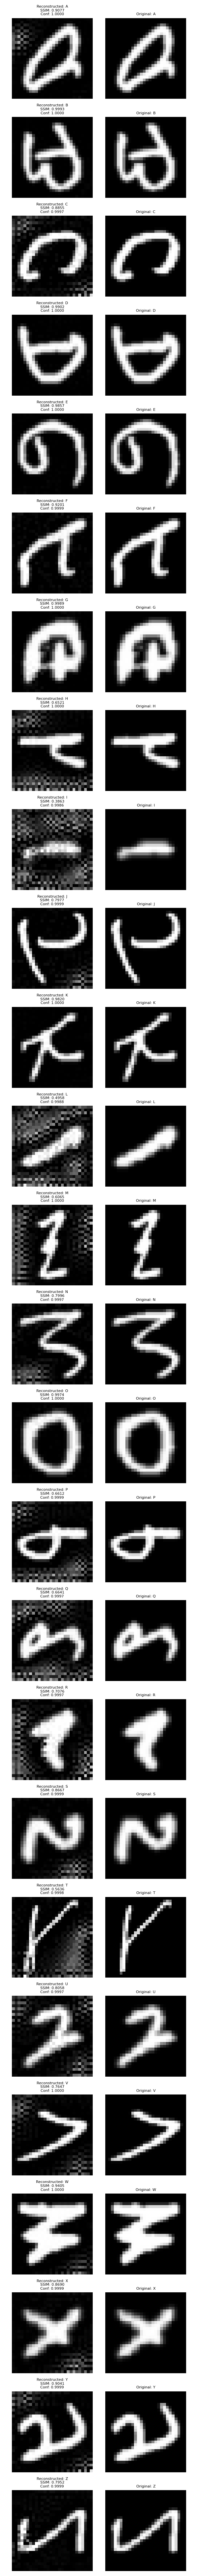

In [21]:
# Figure: Original vs Reconstructed for All Letters (only if processing multiple letters)
if len(target_labels) > 1:
    try:
        num_letters = len(all_results['Letter'])
        print(f'Plotting original vs reconstructed for {num_letters} letters')
        plt.figure(figsize=(6, 3 * num_letters))

        for i, letter in enumerate(all_results['Letter']):
            # Reconstructed image
            plt.subplot(num_letters, 2, 2 * i + 1)
            final_snapshot = letter_data[letter]['snapshots'][-1]
            plt.imshow(final_snapshot, cmap='gray')
            plt.title(f'Reconstructed: {letter}\nSSIM: {all_results["SSIM"][i]:.4f}\nConf: {all_results["Confidence"][i]:.4f}', fontsize=8)
            plt.axis('off')

            # Original image
            plt.subplot(num_letters, 2, 2 * i + 2)
            target_image = letter_data[letter]['target_image']
            plt.imshow(target_image, cmap='gray')
            plt.title(f'Original: {letter}', fontsize=8)
            plt.axis('off')

        plt.tight_layout()
        final_path = './original_vs_reconstructed_all_letters.png'
        plt.savefig(final_path)
        plt.close()
        print(f'Saved side-by-side plot: {final_path}')
        display(Image(filename=final_path))
    except Exception as e:
        print(f'Error saving original vs reconstructed plot: {e}')

## Save Results

Saves the metrics to a CSV file (`./inversion_results_all_letters.csv`) and displays the final results.

In [22]:
# Create and save DataFrame
df_results = pd.DataFrame(all_results)
print('\nFinal Results for All Letters:')
print(df_results)
df_results.to_csv('./inversion_results_all_letters.csv', index=False)
print('Saved CSV: ./inversion_results_all_letters.csv')


Final Results for All Letters:
   Letter      SSIM       MSE  Confidence       CE Loss  Perceptual Loss  \
0       A  0.907748  0.004679    0.999999  9.536739e-07         0.000541   
1       B  0.999323  0.000036    1.000000  0.000000e+00         0.000007   
2       C  0.885469  0.009064    0.999707  2.910667e-04         0.002041   
3       D  0.990171  0.000046    0.999999  8.344647e-07         0.000006   
4       E  0.985748  0.000042    1.000000  0.000000e+00         0.000006   
5       F  0.920148  0.000369    0.999873  1.269498e-04         0.000148   
6       G  0.998852  0.000181    0.999998  1.907347e-06         0.000049   
7       H  0.652059  0.023760    0.999994  5.841238e-06         0.001706   
8       I  0.386259  0.053175    0.998607  1.399253e-03         0.008286   
9       J  0.797749  0.005121    0.999885  1.155071e-04         0.000520   
10      K  0.981998  0.000041    1.000000  0.000000e+00         0.000006   
11      L  0.495832  0.049293    0.998768  1.236985e-03 